# FX System Trade using DQN

## Base Model

### 概要

- トレードは一つの期間に一回のみ
- 使用するNNはLinear
- 入力は15分足のwindow_size分 [[0, 0,...], []]
- forex_data size(window, data_num) 
- lotは1lotで固定
- losscutはなし
- 報酬の与え方
    - 1. 高値更新したら+1, 安値更新したら-1
    - 2. 買った時点より+だったら+0.1, -だったら-0.1, 売却した時+だったら+1, -だったら-1
    - 3. 買った時点との収益パーセントを＋する
- 今回は簡単のため２を採用する

### Library Import

In [4]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from gym import wrappers
from datetime import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from enum import Enum
from typing import NamedTuple, List
import pandas as pd
import os
import uuid
from sklearn.model_selection import train_test_split

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/ruihirano/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Types

In [5]:
class ActionType(Enum):
    NONE = 0
    BUY = 1
    SELL = 2
    
class PositionType(Enum):
    NONE = 0
    LONG = 1
    SHORT = 2
    
class PairType(Enum):
    USD_JPY = 1
    GBP_JPY = 2
    EUR_JPY = 3
    GBP_USD = 4
    EUR_USD = 5
    USD_CHF = 6
    
class GranularityType(Enum):
    W = 1
    D = 2
    H4 = 3
    H1 = 4
    M15 = 5
    M5 = 6
    
class Transaction():
    def __init__(self, start_date: datetime, pair: PairType, lot: float, position: PositionType, entry_rate: float):
        self.id = str(uuid.uuid4())
        self.start_date = start_date
        self.end_date = start_date
        self.pair = pair
        self.lot = lot
        self.position = position
        self.entry_rate = entry_rate
        self.losscut_rate = self.calc_losscut_line()
        self.settle_rate = entry_rate
        self.profit = 0

    def settle(self, end_date, settle_rate):
        self.end_date = end_date
        self.settle_rate = settle_rate
        self.profit = self.calc_profit()
    
    # 利益計算
    def calc_profit(self) -> int:
        if self.position == PositionType.LONG:
            return self.lot * (self.settle_rate - self.entry_rate) * 10000
        else:
            return self.lot * (self.entry_rate - self.settle_rate) * 10000

    # losscutlineを計算
    def calc_losscut_line(self) -> float:
        return 0

    # losscutになるかどうか
    def is_losscut(self, rate: float) -> bool:
        if self.position == PositionType.LONG and rate <= self.losscut_rate or self.position == PositionType.SHORT and rate >= self.losscut_rate:
            return True
        return False

In [6]:
print(ActionType.BUY == ActionType(2))

False


### Utils

In [7]:
def import_csv_data(pair_type: PairType, granularityType:GranularityType):

    dataset_dir = os.path.abspath("../../dataset")
    os.chdir(dataset_dir + "/" + pair_type.name)
    df_data = pd.read_csv(pair_type.name+"_"+granularityType.name+".csv", encoding="utf-8")
    print(df_data)
    return df_data

In [8]:
h1_df = import_csv_data(PairType.USD_JPY, GranularityType.H1)

print(h1_df.close.values)
print(h1_df.close.values.shape)

                            time  volume     high      low     open    close
0      2005-07-01 00:00:00+00:00  2008.0  110.866  110.620  110.740  110.846
1      2005-07-01 01:00:00+00:00  2229.0  111.120  110.820  110.846  110.950
2      2005-07-01 02:00:00+00:00  1610.0  110.990  110.860  110.970  110.860
3      2005-07-01 03:00:00+00:00   834.0  110.920  110.860  110.860  110.900
4      2005-07-01 04:00:00+00:00  1868.0  111.096  110.820  110.900  111.016
...                          ...     ...      ...      ...      ...      ...
93031  2020-01-23 19:00:00+00:00  2389.0  109.536  109.464  109.472  109.523
93032  2020-01-23 20:00:00+00:00  1503.0  109.528  109.476  109.521  109.494
93033  2020-01-23 21:00:00+00:00  1058.0  109.512  109.458  109.495  109.494
93034  2020-01-23 22:00:00+00:00   211.0  109.541  109.484  109.490  109.527
93035  2020-01-23 23:00:00+00:00   928.0  109.572  109.506  109.528  109.567

[93036 rows x 6 columns]
[110.846 110.95  110.86  ... 109.494 109.527 109.5

### Statistics

In [179]:
class Statistics():
    def __init__(self):
        self.total_trade_num=0
        self.win_trade_num=0
        self.lose_trade_num=0
        self.buy_num=0
        self.sell_num=0
        self.win_rate=0
        self.total_profit=0
        self.total_loss=0
        self.profit_average=0
        self.loss_average=0
        self.profit_loss_rate=0
        self.expect_value=0
        self.earn_power=0
        
        self.profit_transition={}   # 利益推移　
        self.loss_transition={}   # 損失推移
        self.profit_loss_transition={}   # 損益推移
        self.total_profit_transition={}   # 合計利益推移　
        self.total_loss_transition={}   # 合計損失推移
        self.total_profit_loss_transition={}   # 合計損益推移
        
    def run(self, transactions):
        self.total_trade_num = len(transactions)
        
        # 売買回数、勝敗回数、総損益
        for transaction in transactions:
            print(transaction.profit)
            if transaction.profit >= 0:
                # Win
                self.win_trade_num += 1
                self.total_profit += transaction.profit
            else:
                # Lose
                self.lose_trade_num += 1
                self.total_loss += transaction.profit

            if transaction.position == PositionType.LONG:
                self.buy_num += 1
            elif transaction.position == PositionType.SHORT:
                self.sell_num += 1
                
            # for Graph
            sdate = transaction.start_date.date()
            profit = transaction.profit
            if sdate in self.profit_loss_transition:  # keyに含まれている場合
                self.profit_loss_transition[sdate] +=  profit
                self.total_profit_loss_transition[sdate] += profit
                if profit >= 0:
                    self.profit_transition[sdate] +=  profit
                    self.total_profit_transition[sdate] += profit
                else:
                    self.loss_transition[sdate] +=  profit
                    self.total_loss_transition[sdate] += profit
            else:   # 初めて追加する場合
                profit_losses = list(self.profit_loss_transition.values())
                self.total_profit_loss_transition[sdate] = sum(profit_losses) + profit  # 前回の総損益を加える
                self.profit_loss_transition[sdate] =  profit
                if profit >= 0:
                    profits = list(self.profit_transition.values())
                    self.total_profit_transition[sdate] = sum(profits) + profit  # 前回の総損益を加える
                    self.profit_transition[sdate] =  profit
                else:
                    losses = list(self.loss_transition.values())
                    self.total_loss_transition[sdate] = sum(losses) + profit  # 前回の総損益を加える
                    self.loss_transition[sdate] =  profit

        # 勝率
        if self.total_trade_num == 0:
            self.win_rate = 0
        else:  
            self.win_rate = self.win_trade_num / self.total_trade_num

        # 平均利益
        if self.win_trade_num == 0:
            self.profit_average = 0
        else:  
            self.profit_average = self.total_profit / self.win_trade_num

        # 平均損失
        if self.lose_trade_num == 0:
            self.loss_average = 0
        else:  
            self.loss_average = self.total_loss / self.lose_trade_num
        
        # 損益率
        if self.loss_average == 0:
            self.profit_loss_rate = 10000
        else:  
            self.profit_loss_rate = abs(self.profit_average / self.loss_average)

        # 期待値と稼力
        self.expect_value = (self.win_rate * self.profit_average) - (-(1-self.win_rate) * self.loss_average)
        self.earn_power = (self.win_rate * self.profit_average) / (-(1-self.win_rate) * self.loss_average)
        
    def show_trade(self):
        print("trade")
        
    def show_graph(self):
        
                
        # グラフ描写
        fig = plt.figure()

        #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)

        # total 
        total_profit_losses_days = list(self.total_profit_loss_transition.keys())
        total_profits_days = list(self.total_profit_transition.keys())
        total_losses_days = list(self.total_loss_transition.keys())
        total_profit_losses = list(self.total_profit_loss_transition.values())
        total_profits = list(self.total_profit_transition.values())
        total_losses = list(self.total_loss_transition.values())
        ax1.set_title("total")
        ax1.plot(total_profit_losses_days, total_profit_losses, color="blue", label="pl")
        ax1.plot(total_profits_days, total_profits, color="red", label="p")
        ax1.plot(total_losses_days, total_losses, color="green", label="l")
        print(total_profit_losses)
        print(total_profits)
        print(total_losses)
        
        # daily
        daily_days = list(self.profit_loss_transition.keys())
        daily_profits_days = list(self.profit_transition.keys())
        daily_losses_days = list(self.loss_transition.keys())
        daily_profit_losses = list(self.profit_loss_transition.values())
        daily_profits = list(self.profit_transition.values())
        daily_losses = list(self.loss_transition.values())
        ax2.set_title("daily")
        ax2.plot(daily_days, daily_profit_losses, color="blue", label="pl")
        ax2.plot(daily_profits_days, daily_profits, color="red", label="p")
        ax2.plot(daily_losses_days, daily_losses, color="green", label="l")
        
        ax1.legend(loc = 'upper right') #凡例
        ax2.legend(loc = 'upper right') #凡例
        fig.tight_layout()              #レイアウトの設定
        plt.show()
        
    def show_stats(self):
        print("--------------------------------------")
        print("TotalTradeNum: ", self.total_trade_num)
        print("WinTradeNum: ", self.win_trade_num)
        print("LoseTradeNum: ", self.lose_trade_num)
        print("BuyNum: ", self.buy_num)
        print("SellNum: ", self.sell_num)
        print("WinRate: ", self.win_rate)
        print("TotalProfit: ", self.total_profit)
        print("TotalLoss: ", self.total_loss)
        print("ProfitAverage: ", self.profit_average)
        print("LossAverage: ", self.loss_average)
        print("ProfitLossRate: ", self.profit_loss_rate)
        print("ExpectValue: ", self.expect_value)
        print("EarnPower: ", self.earn_power)
        print("--------------------------------------")

#### Stats Test

1000.0
2000.0
-2000.0
--------------------------------------
TotalTradeNum:  3
WinTradeNum:  2
LoseTradeNum:  1
BuyNum:  3
SellNum:  0
WinRate:  0.6666666666666666
TotalProfit:  3000.0
TotalLoss:  -2000.0
ProfitAverage:  1500.0
LossAverage:  -2000.0
ProfitLossRate:  0.75
ExpectValue:  333.33333333333326
EarnPower:  1.4999999999999998
--------------------------------------
[1000.0, 3000.0, 1000.0]
[1000.0, 3000.0]
[-2000.0]


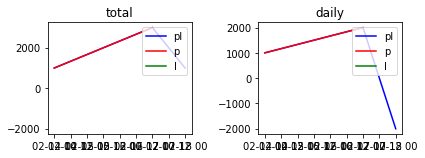

In [180]:
mock_transactions = []
tr1 = Transaction(start_date=datetime(2020, 2, 14), pair=PairType.USD_JPY, lot=0.1, position=PositionType.LONG, entry_rate=100.0)
tr1.settle(end_date=datetime(2020, 2, 14), settle_rate=101.0)
mock_transactions.append(tr1)
tr2 = Transaction(start_date=datetime(2020, 2, 17), pair=PairType.USD_JPY, lot=0.2, position=PositionType.LONG, entry_rate=100.0)
tr2.settle(end_date=datetime.now(), settle_rate=101.0)
mock_transactions.append(tr2)
tr3 = Transaction(start_date=datetime(2020, 2, 18), pair=PairType.USD_JPY, lot=0.2, position=PositionType.LONG, entry_rate=100.0)
tr3.settle(end_date=datetime.now(), settle_rate=99.0)
mock_transactions.append(tr3)

stats = Statistics()
stats.run(mock_transactions)
stats.show_stats()
stats.show_graph()

### ReplayMemory

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        """Saves a transition."""
        #print("args", state, action, next_state, reward)
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


### Environment

In [191]:
### Environment

class EnvParameter(NamedTuple):
    max_lot: int    # 最大数量
    spread: int     # スプレッド
    window_size: int
        
class Environment():
    def __init__(self, data, env_param, MONITOR):
        self.MONITOR = MONITOR
        self.param = env_param
        self.forex_data = data # set forex_data  [t=0 data, t=1 data,....., t=x data]
        self.history = []
        self.steps = self.param.window_size
        
        #if MONITOR:
        #    wrappers.Monitor(self.env, "./tmp", force=True)
    
    def episode_reset(self):
        self.steps = self.param.window_size
        
    def reset(self):
        self.done = False
        self.transaction = None
        self.position = PositionType.NONE
        return self.get_observe()
        
    def step(self, action, lot): # action: 0 is None, 1 is Buy, 2 is Sell
        
        ''' 現ステップの終値と日付 '''
        close = self.forex_data[self.steps] # 現在の15分足
        date = datetime.now() # 現在日時
        action = ActionType(action)
        
        if self.is_build(action):
            ''' 新規取引 '''
            self.position = PositionType.LONG if action == ActionType.BUY else PositionType.SHORT
            self.transaction = Transaction(start_date=date, pair=PairType.USD_JPY, lot=lot, position=self.position, entry_rate=close)

        elif self.is_release(action):
            ''' 決済 '''
            # 取引内容を追記
            self.transaction.settle(end_date=date, settle_rate=close)
            self.history.append(self.transaction)
            # エピソード終了
            self.done = True
        
        ''' 報酬計算 '''
        reward = self.get_reward()

        ''' 次のステップの環境を作成 '''
        self.steps += 1
        next_observe = self.get_observe()

        return next_observe, reward, self.done, self.transaction
        
    def is_release(self, action):
        ''' 決済するかどうか '''
        return self.transaction != None and ((self.position == PositionType.LONG and action == ActionType.SELL) or (self.position == PositionType.SHORT and action == ActionType.BUY))
        
    def is_build(self, action):
        ''' 新規取引するかどうか '''
        return self.transaction == None and (action == ActionType.SELL or action == ActionType.BUY)
    
    def is_finish(self):
        ''' データの最後まで到達したかどうか '''
        return True if self.steps >= len(self.forex_data)-300 else False  # 100step分の余裕を持つ
        
    def get_action_num(self): # action num is 3
        return len(ActionType)
    
    def get_observ_num(self): # observ_num is window_size
        return self.param.window_size
    
    def get_reward(self):
        close = self.forex_data[self.steps]
        if self.transaction == None:
            ''' 取引をしていなければ0 '''
            return -0.1

        elif self.done:    
            ''' 取引終了時にprofitが+であれば+1, -であれば-1 '''
            profit = self.transaction.profit
            return 1.0 if profit >= 0 else -1.0

        else:
            ''' 現在値がトレード時の値より高ければ0.1, 低ければ-0.1 '''
            entry_rate = self.transaction.entry_rate # 取引中のトレードの始値
            return 0.1 if close >= entry_rate else -0.1
    
    def get_observe(self):
        return self.forex_data[self.steps-self.param.window_size: self.steps] # [ws前の15分足, ws+1前の15分足, ..., 現在の15分足]
        
    def show(self):
        return 0
        #if self.MONITOR:
        #    self.env.render()
    
    def close(self):
        return 0
        #if self.MONITOR:
        #    self.env.render(close=True)


#### check

In [13]:
class Test():
    def __init__(self, func):
        self.func = func
        
    def get_reward(self):
        return self.func()

In [14]:
def func():
    return 5

test = Test(func)
test.get_reward()

5

### Agent

In [15]:
class Agent:
    def __init__(self, brain):
        '''エージェントが行動を決定するための頭脳を生成'''
        self.brain = brain
        
    def learn(self):
        '''Q関数を更新する'''
        loss = self.brain.optimize()
        return loss
        
    def modify_goal(self):
        '''Target Networkを更新する'''
        self.brain.update_target_model()
        
    def select_action(self, state):
        '''行動を決定する'''
        action = self.brain.decide_action(state)
        return action
    
    def memorize(self, state, action, next_state, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, next_state, reward)
    
    def predict_action(self, state):
        '''行動を予測する'''
        action = self.brain.predict(state)
        return action
    
    def record(self, name):
        '''モデルを保存する'''
        self.brain.save_model(name)
        
    def remember(self, name):
        '''モデルを読み込む'''
        self.brain.read_model(name)

### Trainer

In [192]:
class Trainer():
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.profit_durations = [0]
        self.total_profit_durations = [0]
        self.loss_durations = []
        self.TARGET_UPDATE = 10
        self.episode = 0
        
    def train(self, episode_num, save_name):
        for episode_i in range(episode_num):
            print("episode: ", episode_i)
            self.env.episode_reset()
            while self.env.is_finish() == False:
                state = self.env.reset()
                print("episode: ", episode_i)
                for t in count():
                    print("step: ", t)
                    ''' 行動を決定する '''
                    # Select and perform an action
                    action = self.agent.select_action(state) # input ex: <list> [0, 0, 0, 0], output ex: <int> 0 or 1
                    print("action", action)
                    lot = 1

                    ''' 行動に対する環境や報酬を取得する '''
                    next_state, reward, done, transaction = self.env.step(action, lot)  # state [0,0,0,0...window_size], reward 1.0, done False, input: action 0 or 1 or 2

                    ''' 終了時はnext_state_valueをNoneとする '''
                    if done:
                        next_state_value = None
                    else:
                        next_state_value = torch.tensor([next_state], device=device, dtype=torch.float32)
                    #print("after action: {0}, state: {1}, next_state: {2}, reward: {3} done: {4}".format(action, state, next_state, reward, done))


                    ''' エージェントに記憶させる '''
                    # Store the transition in memory
                    self.agent.memorize(
                        torch.tensor([state], device=device, dtype=torch.float32), 
                        torch.tensor([[action]], device=device), 
                        next_state_value, 
                        torch.tensor([reward], device=device)
                    )

                    # Move to the next state
                    state = next_state

                    ''' エージェントに学習させる '''
                    # Perform one step of the optimization (on the target network)
                    # update q network
                    loss = self.agent.learn()
                    print("loss: ", loss)
                    if loss != None:
                        self.loss_durations.append(loss)

                    if done:
                        ''' 終了時に結果をプロット '''
                        print("sdate: {0}, edate: {1}, position: {2}, profit: {3}".format(transaction.start_date, transaction.end_date, transaction.position, transaction.profit))
                        total_profit = transaction.profit + self.total_profit_durations[-1]
                        self.total_profit_durations.append(total_profit)
                        self.profit_durations.append(transaction.profit)
                        self.plot_durations()
                        #self.episode += 1
                        break
            # Update the target network, copying all weights and biases in DQN
            if self.episode % self.TARGET_UPDATE == 0:
                ''' 目標を修正する '''
                self.agent.modify_goal()

        ''' モデルを保存する '''
        # モデルの保存
        self.agent.record(save_name)
        print('Complete')
        
        
    def plot_durations(self):
        #figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
        fig = plt.figure()

        #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)

        x1 = [s for s in range(len(self.profit_durations))]
        y1 = self.profit_durations
        x2 = [s for s in range(len(self.total_profit_durations))]
        y2 = self.total_profit_durations
        x3 = [s for s in range(len(self.loss_durations))]
        y3 = self.loss_durations

        c1,c2,c3 = "blue","green", "red"      # 各プロットの色
        l1,l2,l3 = "profit","total", "loss"   # 各ラベル

        ax1.plot(x1, y1, color=c1, label=l1)
        ax2.plot(x2, y2, color=c2, label=l2)
        ax3.plot(x3, y3, color=c3, label=l3)
        ax1.legend(loc = 'upper right') #凡例
        ax2.legend(loc = 'upper right') #凡例
        ax3.legend(loc = 'upper right') #凡例
        fig.tight_layout()              #レイアウトの設定
        plt.show()


- Test

### Examiner

In [17]:
class Examiner():
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.profit_durations = [0]
        self.total_profit_durations = [0]
        self.episode = 0
        self.stats = Statistics()
        self.transactions = []
        
    def evaluate(self, file_name):
        self.agent.remember(file_name)
        
        while self.env.is_finish() == False:
            print("episode: ", self.episode)
            state = self.env.reset()
            for t in count():
                #self.env.show()
                
                ''' 行動を決定する '''
                action = self.agent.predict_action(state) # input ex: <list> [0, 0, 0, 0], output ex: <int> 0 or 1
                #print("action: ", action)
                lot = 1
                
                ''' 行動に対する環境や報酬を取得する '''
                next_state, reward, done, transaction = self.env.step(action, lot)  # state [0,0,0,0...window_size], reward 1.0, done False, input: action 0 or 1 or 2
                
                # Move to the next state
                state = next_state

                if done:
                    ''' 終了時に結果をプロット '''
                    print("step: ", t)
                    print("sdate: {0}, edate: {1}, position: {2}, profit: {3}".format(transaction.start_date, transaction.end_date, transaction.position, transaction.profit))
                    total_profit = transaction.profit + self.total_profit_durations[-1]
                    self.total_profit_durations.append(total_profit)
                    self.profit_durations.append(transaction.profit)
                    self.plot_durations()
                    self.transactions.append(transaction)
                    self.episode += 1
                    break
                    
        #self.env.close()
        ''' 統計計算 '''
        self.stats.run(self.transactions)
        self.stats.show()
        print('Complete')
                    
    def plot_durations(self):
        #figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
        fig = plt.figure()

        #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        x1 = [s for s in range(len(self.profit_durations))]
        y1 = self.profit_durations
        x2 = [s for s in range(len(self.total_profit_durations))]
        y2 = self.total_profit_durations

        c1,c2 = "blue","green"      # 各プロットの色
        l1,l2 = "profit","total"   # 各ラベル

        ax1.plot(x1, y1, color=c1, label=l1)
        ax2.plot(x2, y2, color=c2, label=l2)
        ax1.legend(loc = 'upper right') #凡例
        ax2.legend(loc = 'upper right') #凡例
        fig.tight_layout()              #レイアウトの設定
        plt.show()

## Linear DQN

### DQN

In [18]:
class DQN(nn.Module):

    def __init__(self, inputs_num, hidden_size, outputs_num):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs_num, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, outputs_num)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        y = F.relu(self.fc4(h))
        return y


### Brain

In [19]:
class BrainParameter(NamedTuple):
    batch_size: int
    gamma : float
    eps_start : float
    eps_end: float
    eps_decay: int
    capacity: int
    hidden_size: int

class Brain:
    def __init__(self, param, num_observ, num_actions):
        self.steps_done = 0
        
        # Brain Parameter
        self.BATCH_SIZE = param.batch_size
        self.GAMMA = param.gamma
        self.EPS_START = param.eps_start
        self.EPS_END = param.eps_end
        self.EPS_DECAY = param.eps_decay
        self.CAPACITY = param.capacity
        self.HIDDEN_SIZE = param.hidden_size
        
        # 経験を保存するメモリオブジェクトを生成
        self.memory = ReplayMemory(self.CAPACITY)
        
        #print(self.model) # ネットワークの形を出力
        self.num_observ = num_observ
        #print(self.num_observ)
        self.num_actions = num_actions # 行動の数を取得
        self.policy_net = DQN(self.num_observ, self.HIDDEN_SIZE, self.num_actions).to(device)
        self.target_net = DQN(self.num_observ, self.HIDDEN_SIZE, self.num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        # 最適化手法の設定
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        
    def optimize(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        
        # 訓練モード
        self.policy_net.train()
        
        ''' batch化する '''
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state) # state: tensor([[0.5, 0.4, 0.5, 0], ...]) size(32, 4)
        action_batch = torch.cat(batch.action) # action: tensor([[1],[0],[0]...]) size(32, 1) 
        reward_batch = torch.cat(batch.reward) # reward: tensor([1, 1, 1, 0, ...]) size(32)
        #print("state_batch: ", state_batch, state_batch.size())
        #print("action_batch: ", action_batch, action_batch.size())
        #print("reward_batch: ", reward_batch, reward_batch.size())


        ''' 出力データ：行動価値を作成 '''
        # 出力actionの値のうちaction_batchが選んだ方を抽出（.gather()）
        # action_batch = [[0], [1], [1]...] action_value = [[0.01, 0.03], [0.03, 0], [0, 0.02]...]
        # state_action_values = [[0.01], [0], [0.02]]
        state_action_values = self.policy_net(state_batch).gather(1, action_batch) # size(32, 1)
        #print("state_action_values2", self.policy_net(state_batch), self.policy_net(state_batch).size())
        #print("state_action_values", state_action_values, state_action_values.size())

        ''' 教師データを作成する '''
        ''' target = 次のステップでの行動価値の最大値 * 時間割引率 + 即時報酬 '''
         # doneされたかどうか doneであればfalse
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        #print("non_final_mask: ", non_final_mask, non_final_mask.size())
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        #print("non_final_next_state: ", non_final_next_states, non_final_next_states.size())
        
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        
        # 大きい方を選択して一次元にする
        # done時は0
        # target_net: [[0, 0.1], [2, 0.2]...], size(32, 2)      next_state_values: [0.1, 2...], size(32)
        # 次の環境での行動価値
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach() # size(32)

        # target = 次のステップでの行動価値の最大値 * 時間割引率 + 即時報酬
        expected_state_action_values = ((next_state_values * self.GAMMA) + reward_batch).unsqueeze(1) # size(32, 1)
        #print("expected_state_value: ", expected_state_action_values, expected_state_action_values.size())

        ''' Loss を計算'''
        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

        ''' 勾配計算、更新 '''
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss
    
    def update_target_model(self):
        # モデルの重みをtarget_networkにコピー
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decide_action(self, state):
        state = torch.tensor(state, device=device).float()
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                action = np.argmax(self.policy_net(state).tolist())
                return action
        else:
            return random.randrange(self.num_actions)
    
    
    def save_model(self, name):
        torch.save(self.policy_net.state_dict(), name)
        
    def read_model(self, name):
        param = torch.load(name)
        self.policy_net.load_state_dict(param)
    
    def predict(self, state):
        state = torch.tensor(state, device=device).float()
        self.policy_net.eval() # ネットワークを推論モードに切り替える
        with torch.no_grad():
            action = np.argmax(self.policy_net(state).tolist())
        return action


## Main(Train)

### DataSet

In [20]:
def get_data():
    h1_df = import_csv_data(PairType.USD_JPY, GranularityType.H1)
    h1_df["log_ratio"] = np.log(h1_df['close'])-np.log(h1_df['close'].shift(1))
    h1_df = h1_df.dropna(how='any')
    # z-score normalization
    standardized_h1_df = (h1_df["log_ratio"] - h1_df["log_ratio"].mean()) / h1_df["log_ratio"].std()
    print("standardized", standardized_h1_df)
    # min-max normalization
    normalized_h1_df = (h1_df["log_ratio"] - h1_df["log_ratio"].min()) / (h1_df["log_ratio"].max() - h1_df["log_ratio"].min())
    print("normlized", normalized_h1_df)
    return standardized_h1_df.values

In [197]:
train_valid_data, test_data = train_test_split(get_data(), test_size=0.2)
train_data, valid_data = train_test_split(train_valid_data, test_size=0.98)
print("train_data: ", train_data.shape)
print("valid_data: ", valid_data.shape)
print("test_data: ", test_data.shape)

                            time  volume     high      low     open    close
0      2005-07-01 00:00:00+00:00  2008.0  110.866  110.620  110.740  110.846
1      2005-07-01 01:00:00+00:00  2229.0  111.120  110.820  110.846  110.950
2      2005-07-01 02:00:00+00:00  1610.0  110.990  110.860  110.970  110.860
3      2005-07-01 03:00:00+00:00   834.0  110.920  110.860  110.860  110.900
4      2005-07-01 04:00:00+00:00  1868.0  111.096  110.820  110.900  111.016
...                          ...     ...      ...      ...      ...      ...
93031  2020-01-23 19:00:00+00:00  2389.0  109.536  109.464  109.472  109.523
93032  2020-01-23 20:00:00+00:00  1503.0  109.528  109.476  109.521  109.494
93033  2020-01-23 21:00:00+00:00  1058.0  109.512  109.458  109.495  109.494
93034  2020-01-23 22:00:00+00:00   211.0  109.541  109.484  109.490  109.527
93035  2020-01-23 23:00:00+00:00   928.0  109.572  109.506  109.528  109.567

[93036 rows x 6 columns]
standardized 1        0.721740
2       -0.624364
3

### Main

episode:  0
episode:  0
step:  0
action 1
loss:  None
step:  1
action 2
loss:  None
sdate: 2020-03-08 00:24:18.855909, edate: 2020-03-08 00:24:18.856343, position: PositionType.LONG, profit: -6927.733723396909


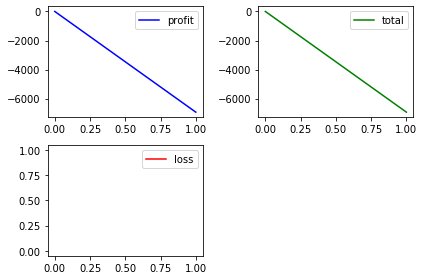

episode:  0
step:  0
action 1
loss:  None
step:  1
action 2
loss:  None
sdate: 2020-03-08 00:24:19.206812, edate: 2020-03-08 00:24:19.207426, position: PositionType.LONG, profit: -10579.77680224023


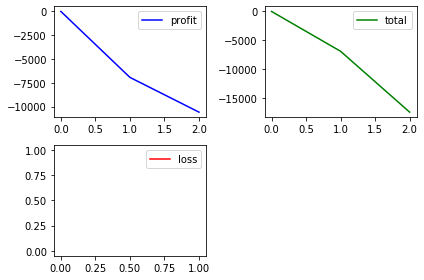

episode:  0
step:  0
action 1
loss:  None
step:  1
action 0
loss:  None
step:  2
action 1
loss:  None
step:  3
action 0
loss:  None
step:  4
action 2
loss:  None
sdate: 2020-03-08 00:24:19.530298, edate: 2020-03-08 00:24:19.531278, position: PositionType.LONG, profit: 1276.9733147599404


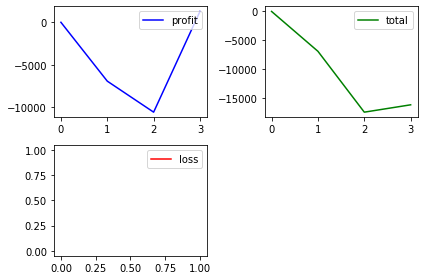

episode:  0
step:  0
action 1
loss:  None
step:  1
action 2
loss:  None
sdate: 2020-03-08 00:24:19.862624, edate: 2020-03-08 00:24:19.862771, position: PositionType.LONG, profit: -3297.619428719809


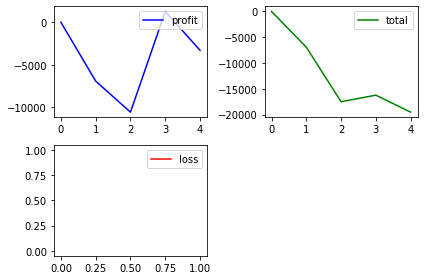

episode:  0
step:  0
action 2
loss:  None
step:  1
action 0
loss:  None
step:  2
action 0
loss:  None
step:  3
action 1
loss:  None
sdate: 2020-03-08 00:24:20.236906, edate: 2020-03-08 00:24:20.237665, position: PositionType.SHORT, profit: 702.1589741837322


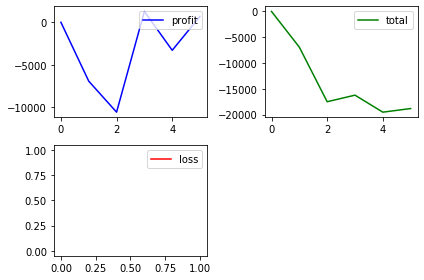

episode:  0
step:  0
action 0
loss:  None
step:  1
action 0
loss:  None
step:  2
action 1
loss:  None
step:  3
action 0
loss:  None
step:  4
action 0
loss:  None
step:  5
action 1
loss:  None
step:  6
action 1
loss:  None
step:  7
action 1
loss:  None
step:  8
action 1
loss:  None
step:  9
action 2
loss:  None
sdate: 2020-03-08 00:24:20.577181, edate: 2020-03-08 00:24:20.582438, position: PositionType.LONG, profit: -7887.786531537864


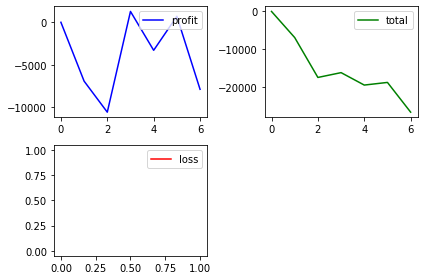

episode:  0
step:  0
action 2
loss:  None
step:  1
action 1
loss:  None
sdate: 2020-03-08 00:24:20.954717, edate: 2020-03-08 00:24:20.955208, position: PositionType.SHORT, profit: 4062.499059612912


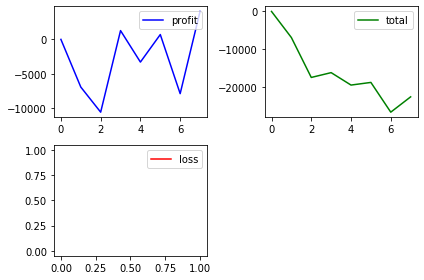

episode:  0
step:  0
action 2
loss:  None
step:  1
action 0
loss:  None
step:  2
action 2
loss:  None
step:  3
action 1
loss:  None
sdate: 2020-03-08 00:24:21.289934, edate: 2020-03-08 00:24:21.294623, position: PositionType.SHORT, profit: -1284.745104139375


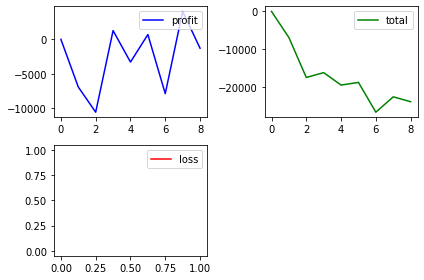

episode:  0
step:  0
action 0
loss:  tensor(0.1299, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(4.0544, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.1322, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1328, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.1314, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.1328, grad_fn=<SmoothL1LossBackward>)
step:  6
action 2
loss:  tensor(0.1022, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:21.666483, edate: 2020-03-08 00:24:21.684331, position: PositionType.LONG, profit: -640.7457938904423


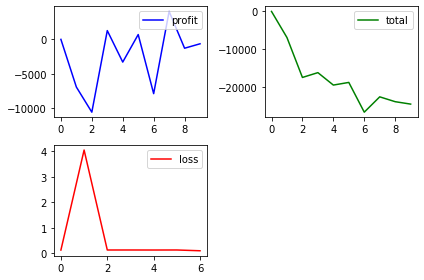

episode:  0
step:  0
action 0
loss:  tensor(0.1311, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1333, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1158, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1016, grad_fn=<SmoothL1LossBackward>)
step:  4
action 1
loss:  tensor(0.0715, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.1171, grad_fn=<SmoothL1LossBackward>)
step:  6
action 2
loss:  tensor(0.1326, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:22.077716, edate: 2020-03-08 00:24:22.085617, position: PositionType.LONG, profit: 18119.645045473582


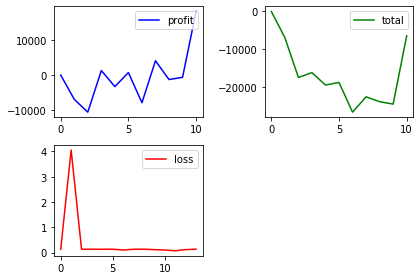

episode:  0
step:  0
action 2
loss:  tensor(0.1026, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1013, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.0715, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1318, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.1177, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0716, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.1337, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:22.410579, edate: 2020-03-08 00:24:22.435646, position: PositionType.SHORT, profit: 3152.6166341904814


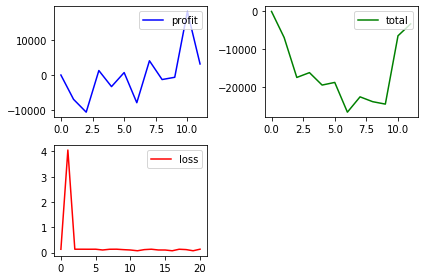

episode:  0
step:  0
action 0
loss:  tensor(0.1484, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(0.1034, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1185, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1176, grad_fn=<SmoothL1LossBackward>)
step:  4
action 1
loss:  tensor(0.0875, grad_fn=<SmoothL1LossBackward>)
step:  5
action 2
loss:  tensor(0.0870, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:22.783567, edate: 2020-03-08 00:24:22.798521, position: PositionType.LONG, profit: -1269.2529736548508


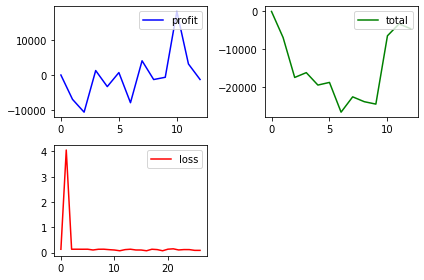

episode:  0
step:  0
action 0
loss:  tensor(0.1474, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1004, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.1010, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1174, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.1034, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.1327, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.1324, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:23.143112, edate: 2020-03-08 00:24:23.159140, position: PositionType.SHORT, profit: 15437.003422364553


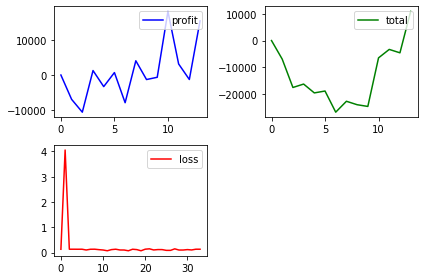

episode:  0
step:  0
action 0
loss:  tensor(0.0701, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1033, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1170, grad_fn=<SmoothL1LossBackward>)
step:  3
action 1
loss:  tensor(0.1171, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0867, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.1032, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.1010, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.1035, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.1166, grad_fn=<SmoothL1LossBackward>)
step:  9
action 1
loss:  tensor(0.1001, grad_fn=<SmoothL1LossBackward>)
step:  10
action 1
loss:  tensor(0.1180, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0413, grad_fn=<SmoothL1LossBackward>)
step:  12
action 1
loss:  tensor(0.1475, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0877, grad_fn=

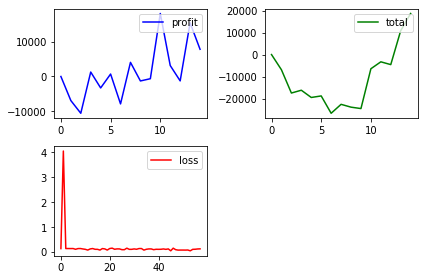

episode:  0
step:  0
action 0
loss:  tensor(0.0593, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1348, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.0556, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1201, grad_fn=<SmoothL1LossBackward>)
step:  4
action 1
loss:  tensor(0.0565, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:24.410877, edate: 2020-03-08 00:24:24.419040, position: PositionType.SHORT, profit: -11476.771039516012


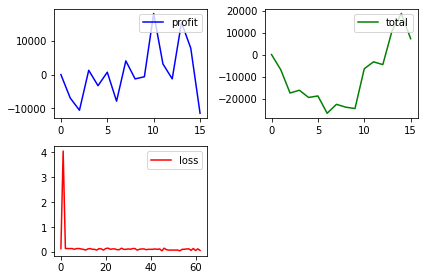

episode:  0
step:  0
action 0
loss:  tensor(0.1479, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(0.1177, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0739, grad_fn=<SmoothL1LossBackward>)
step:  3
action 2
loss:  tensor(0.0718, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:24.803206, edate: 2020-03-08 00:24:24.811628, position: PositionType.LONG, profit: -10331.12700682058


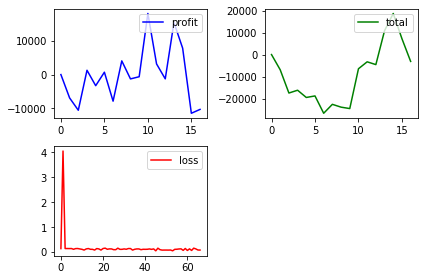

episode:  0
step:  0
action 0
loss:  tensor(0.0748, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1030, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0733, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0591, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0732, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0411, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.1477, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.1487, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0407, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0580, grad_fn=<SmoothL1LossBackward>)
step:  10
action 2
loss:  tensor(0.0860, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:25.211296, edate: 2020-03-08 00:24:25.227032, position: PositionType.LONG, profit: -2873.2187755135697


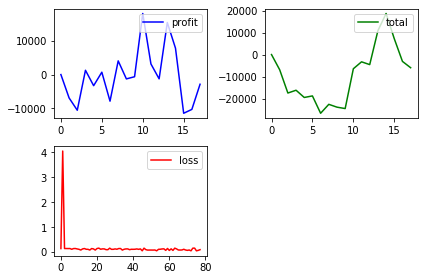

episode:  0
step:  0
action 0
loss:  tensor(0.1172, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0731, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0875, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1028, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0877, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0364, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0538, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0547, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0848, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0575, grad_fn=<SmoothL1LossBackward>)
step:  10
action 1
loss:  tensor(0.0676, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0556, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0725, grad_fn=<SmoothL1LossBackward>)
step:  13
action 2
loss:  tensor(0.0716, grad_fn=

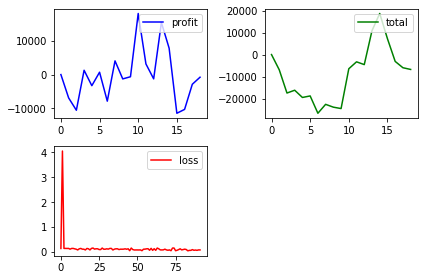

episode:  0
step:  0
action 1
loss:  tensor(0.0723, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0678, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.0546, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0237, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0711, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0729, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0730, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0843, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0739, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0702, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.1045, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0739, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0409, grad_fn=<SmoothL1LossBackward>)
step:  13
action 2
loss:  tensor(0.0710, grad_fn=

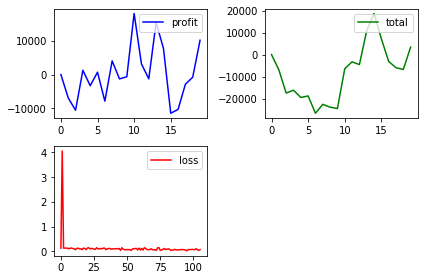

episode:  0
step:  0
action 0
loss:  tensor(0.0697, grad_fn=<SmoothL1LossBackward>)
step:  1
action 2
loss:  tensor(0.0851, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.0250, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0559, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0884, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0703, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0585, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0284, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0426, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0751, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.1028, grad_fn=<SmoothL1LossBackward>)
step:  11
action 2
loss:  tensor(0.0737, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0858, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.1041, grad_fn=

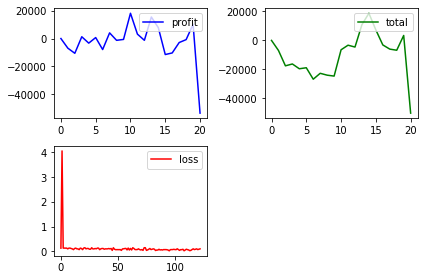

episode:  0
step:  0
action 2
loss:  tensor(0.1326, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0397, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1033, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0769, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.0766, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0711, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:26.820228, edate: 2020-03-08 00:24:26.841629, position: PositionType.SHORT, profit: 22216.702519927916


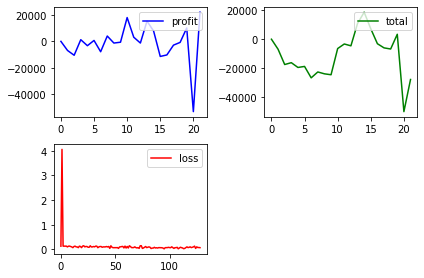

episode:  0
step:  0
action 1
loss:  tensor(0.1183, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(0.0411, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0554, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0919, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.1325, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:27.192752, edate: 2020-03-08 00:24:27.211539, position: PositionType.LONG, profit: -2398.6553313499467


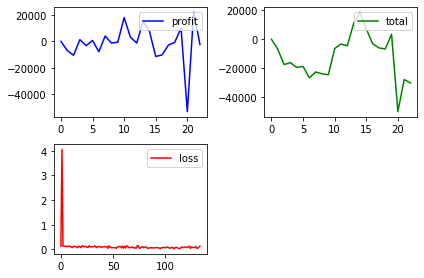

episode:  0
step:  0
action 0
loss:  tensor(0.0736, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(0.0737, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0714, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0589, grad_fn=<SmoothL1LossBackward>)
step:  4
action 1
loss:  tensor(0.1063, grad_fn=<SmoothL1LossBackward>)
step:  5
action 2
loss:  tensor(0.0446, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:27.565223, edate: 2020-03-08 00:24:27.581204, position: PositionType.LONG, profit: 3422.7938629354917


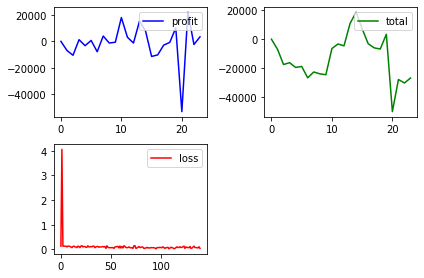

episode:  0
step:  0
action 0
loss:  tensor(0.0399, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0411, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.1341, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.1046, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.1491, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.1197, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.1025, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.1184, grad_fn=<SmoothL1LossBackward>)
step:  8
action 2
loss:  tensor(0.0707, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:27.934517, edate: 2020-03-08 00:24:27.955956, position: PositionType.LONG, profit: -9917.792901757217


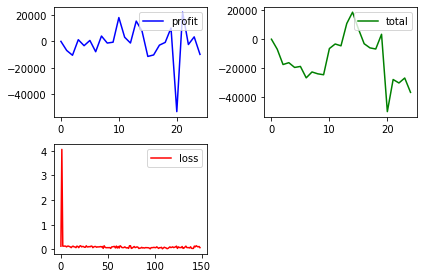

episode:  0
step:  0
action 0
loss:  tensor(0.0422, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0889, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.0573, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0572, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0592, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.1332, grad_fn=<SmoothL1LossBackward>)
step:  6
action 2
loss:  tensor(0.0876, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0878, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:28.404472, edate: 2020-03-08 00:24:28.423058, position: PositionType.SHORT, profit: -13384.908986421864


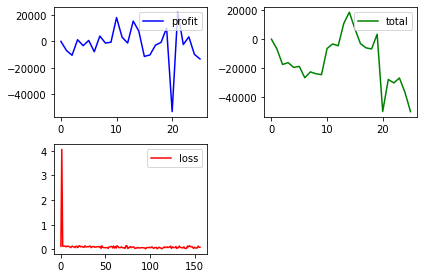

episode:  0
step:  0
action 0
loss:  tensor(0.0247, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0698, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0844, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0892, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0567, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0241, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0702, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0545, grad_fn=<SmoothL1LossBackward>)
step:  8
action 2
loss:  tensor(0.0538, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.1189, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0695, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.1062, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0564, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0416, grad_fn=

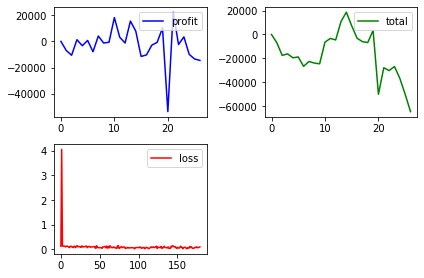

episode:  0
step:  0
action 2
loss:  tensor(0.0695, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0714, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.0717, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:29.187540, edate: 2020-03-08 00:24:29.196157, position: PositionType.SHORT, profit: 17230.76272482059


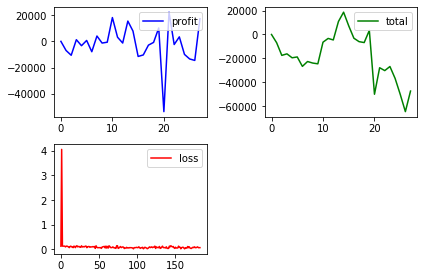

episode:  0
step:  0
action 0
loss:  tensor(0.0717, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0576, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0580, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0853, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0862, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0710, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.1330, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0541, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.1007, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0867, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0548, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0870, grad_fn=<SmoothL1LossBackward>)
step:  12
action 1
loss:  tensor(0.0729, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0858, grad_fn=

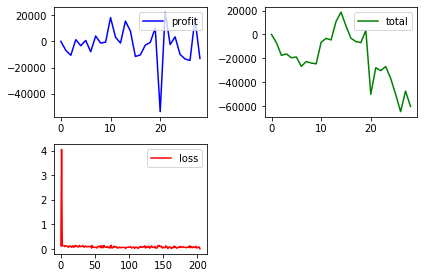

episode:  0
step:  0
action 0
loss:  tensor(0.0400, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0917, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1064, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0394, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0382, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0544, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.1004, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0265, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.0876, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.1028, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0525, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0389, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0561, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0559, grad_fn=

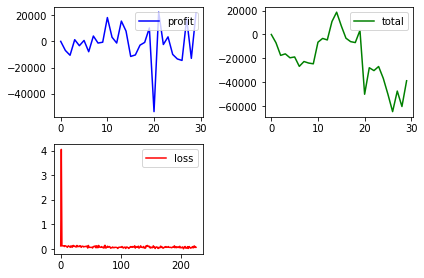

episode:  0
step:  0
action 0
loss:  tensor(0.0591, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0557, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0887, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0730, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.1020, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.1032, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0691, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0572, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0262, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0719, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0707, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0734, grad_fn=<SmoothL1LossBackward>)
step:  12
action 2
loss:  tensor(0.0401, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0430, grad_fn=

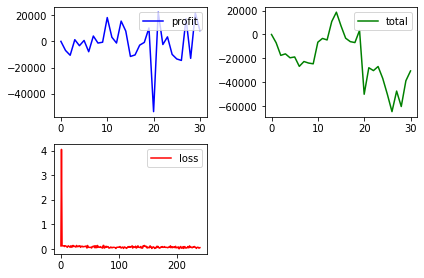

episode:  0
step:  0
action 0
loss:  tensor(0.0683, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0990, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0859, grad_fn=<SmoothL1LossBackward>)
step:  3
action 1
loss:  tensor(0.0278, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.0864, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:30.765703, edate: 2020-03-08 00:24:30.769442, position: PositionType.LONG, profit: -11588.915400747099


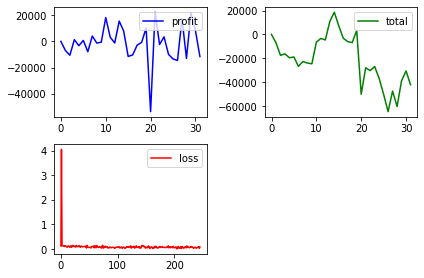

episode:  0
step:  0
action 0
loss:  tensor(0.0387, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0558, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0848, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0616, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0409, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0719, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0534, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0848, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.0854, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.1001, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0992, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0260, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0839, grad_fn=<SmoothL1LossBackward>)
step:  13
action 1
loss:  tensor(0.0575, grad_fn=

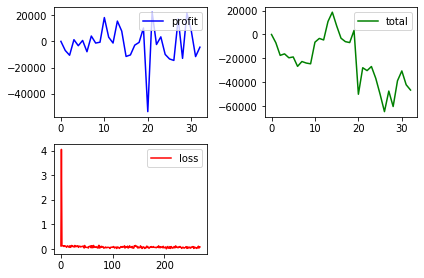

episode:  0
step:  0
action 0
loss:  tensor(0.0557, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1004, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0407, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0378, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.0848, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0540, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0691, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0867, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0555, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0372, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0368, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0411, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0387, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0554, grad_fn=

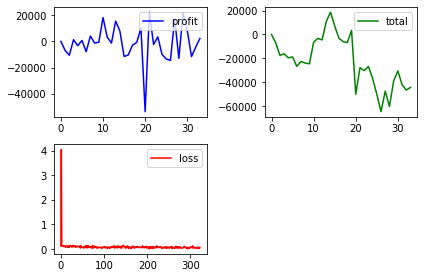

episode:  0
step:  0
action 0
loss:  tensor(0.0538, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0106, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0565, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0222, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0675, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0554, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.1039, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0705, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0570, grad_fn=<SmoothL1LossBackward>)
step:  9
action 1
loss:  tensor(0.0551, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0428, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0852, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0548, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0730, grad_fn=

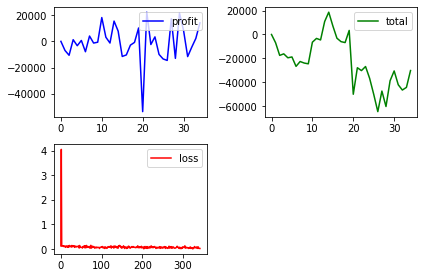

episode:  0
step:  0
action 0
loss:  tensor(0.0576, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0702, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0722, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0249, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0449, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0710, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0562, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0376, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0395, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0296, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0280, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0704, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0710, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0881, grad_fn=

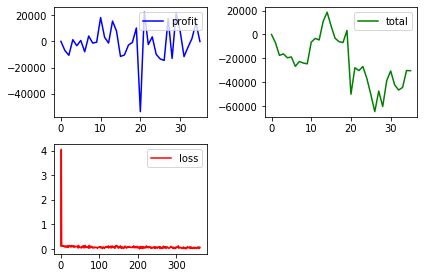

episode:  0
step:  0
action 2
loss:  tensor(0.0695, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0556, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.1022, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0405, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0994, grad_fn=<SmoothL1LossBackward>)
step:  5
action 2
loss:  tensor(0.0553, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0085, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0849, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0874, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0409, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0720, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0703, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0871, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0396, grad_fn=

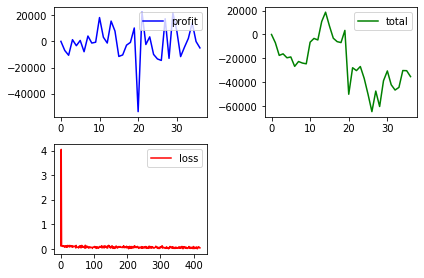

episode:  0
step:  0
action 0
loss:  tensor(0.0729, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0997, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0538, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0087, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.0097, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0726, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0386, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0708, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0417, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0087, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0386, grad_fn=<SmoothL1LossBackward>)
step:  11
action 2
loss:  tensor(0.0106, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0269, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0410, grad_fn=

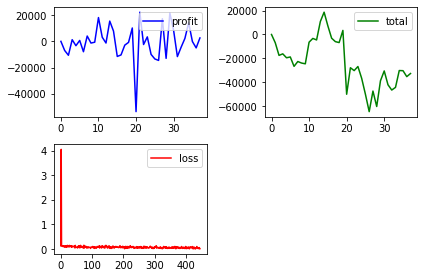

episode:  0
step:  0
action 0
loss:  tensor(0.0418, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0546, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0394, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0414, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0840, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0224, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0842, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0091, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0568, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0230, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.1018, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0842, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0141, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0720, grad_fn=

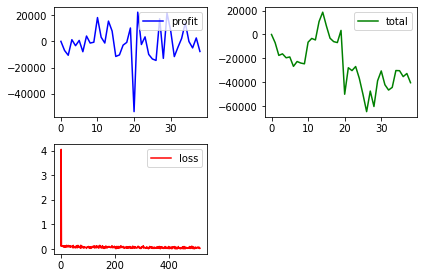

episode:  0
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1042, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0545, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0707, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0383, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0227, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0238, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0838, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0223, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0567, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0123, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0383, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0094, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0265, grad_fn=

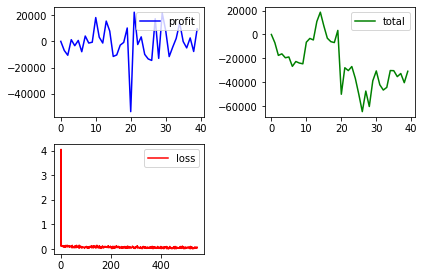

episode:  0
step:  0
action 0
loss:  tensor(0.0371, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.1174, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0111, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0695, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0239, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0066, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0394, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0559, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.0083, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0573, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0508, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0548, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0381, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0080, grad_fn=

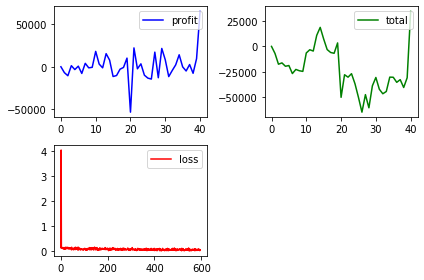

episode:  0
step:  0
action 2
loss:  tensor(0.0268, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0128, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0546, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0391, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0888, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0564, grad_fn=<SmoothL1LossBackward>)
step:  6
action 2
loss:  tensor(0.0535, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0125, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0401, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0408, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0284, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0370, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0278, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0210, grad_fn=

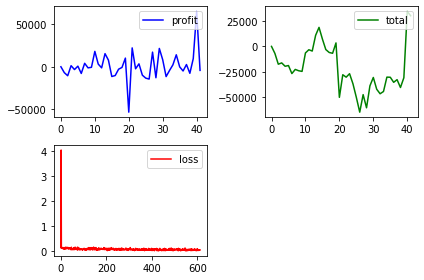

episode:  0
step:  0
action 0
loss:  tensor(0.0728, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0886, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0452, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0853, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0411, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0544, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0408, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0382, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0269, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0085, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.1012, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0703, grad_fn=<SmoothL1LossBackward>)
step:  12
action 2
loss:  tensor(0.0547, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0549, grad_fn=

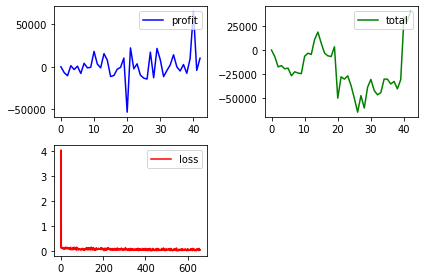

episode:  0
step:  0
action 1
loss:  tensor(0.0383, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0211, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0716, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0583, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0244, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0420, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0852, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0569, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0706, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0133, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0398, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0576, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0296, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0573, grad_fn=

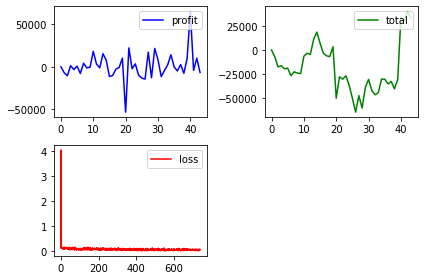

episode:  0
step:  0
action 0
loss:  tensor(0.0108, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0573, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0561, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0100, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0241, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0090, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0059, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0249, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0550, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0354, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0543, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0683, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0417, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0386, grad_fn=

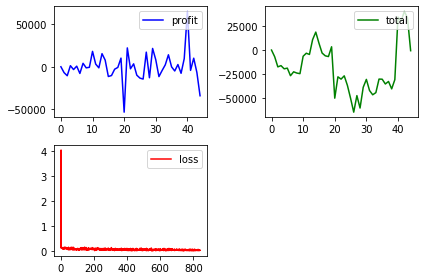

episode:  0
step:  0
action 0
loss:  tensor(0.0548, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0691, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0235, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0077, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0516, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0114, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0084, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0545, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0078, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0236, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0100, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0099, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0281, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0539, grad_fn=

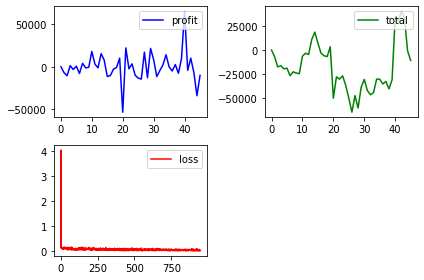

episode:  0
step:  0
action 0
loss:  tensor(0.0106, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0252, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.0231, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0523, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0364, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0389, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0076, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0241, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0212, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0089, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0418, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0684, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0077, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0546, grad_fn=

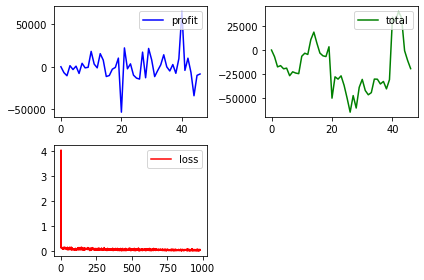

episode:  0
step:  0
action 0
loss:  tensor(0.0077, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0106, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0072, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0385, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0583, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0076, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0524, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0216, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0099, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0069, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0525, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0083, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0404, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0259, grad_fn=

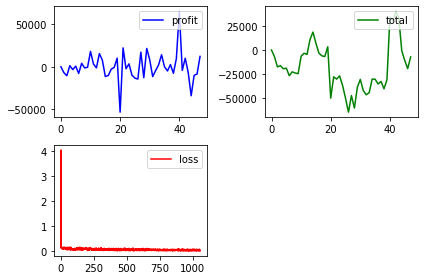

episode:  0
step:  0
action 0
loss:  tensor(0.0240, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0229, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0828, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0374, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0370, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0369, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0245, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0210, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0380, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0219, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0371, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0418, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0057, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.1035, grad_fn=

action 0
loss:  tensor(0.0111, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0099, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0103, grad_fn=<SmoothL1LossBackward>)
step:  152
action 2
loss:  tensor(0.0229, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:40.558009, edate: 2020-03-08 00:24:40.821116, position: PositionType.LONG, profit: -18446.293280006597


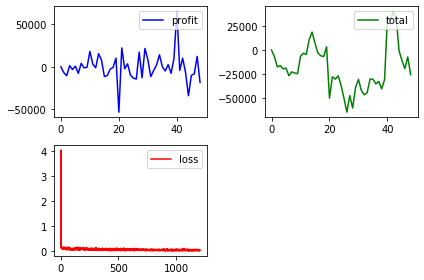

episode:  1
episode:  1
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.00

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL

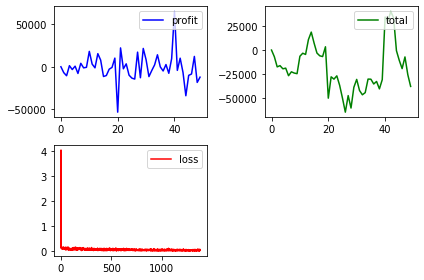

episode:  1
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 1
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0514, grad_fn=

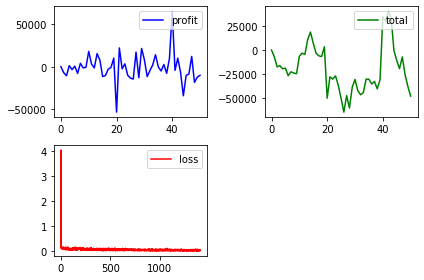

episode:  1
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

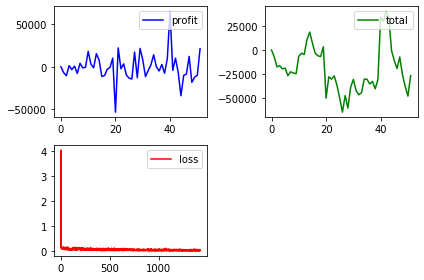

episode:  1
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL

action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  306
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  307
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  308
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  309
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  310
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  311
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  312
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  313
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  314
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  315
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  316
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  317
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  318
action 0
loss:  tensor(0.0205, grad_fn

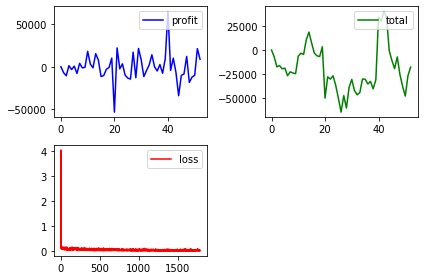

episode:  1
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0514, grad_fn=

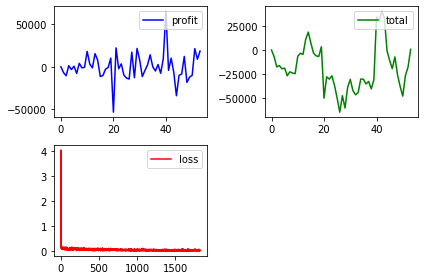

episode:  1
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

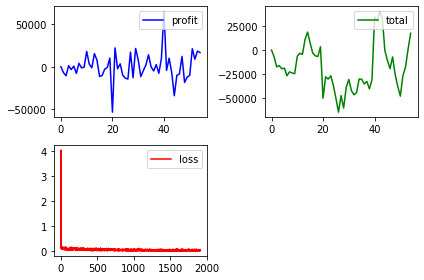

episode:  1
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:24:46.127838, edate: 2020-03-08 00:24:46.140003, position: PositionType.SHORT, profit: 5921.068574549357


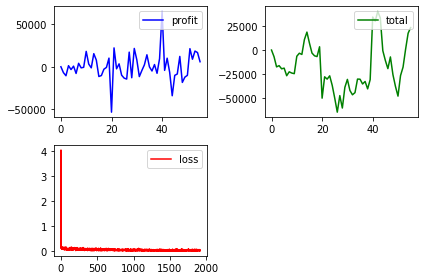

episode:  1
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

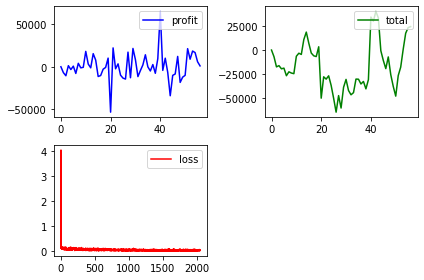

episode:  1
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

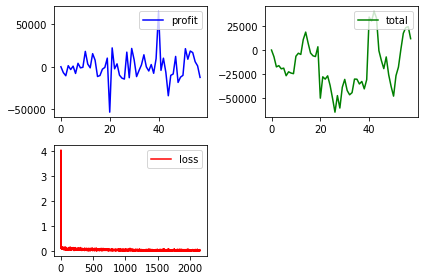

episode:  1
step:  0
action 0
loss:  tensor(0.0823, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

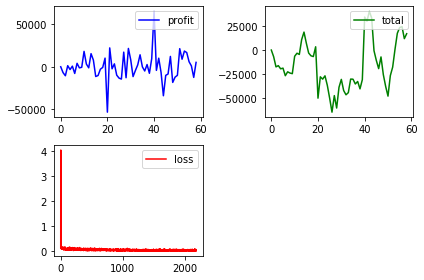

episode:  1
step:  0
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

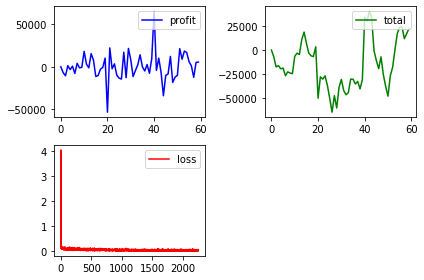

episode:  1
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

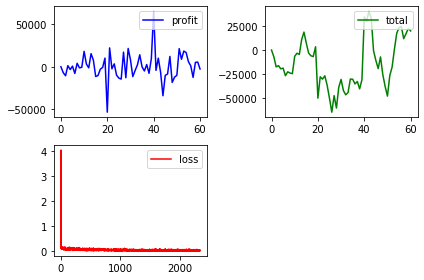

episode:  1
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

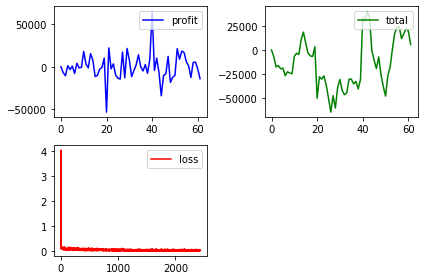

episode:  2
episode:  2
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.02

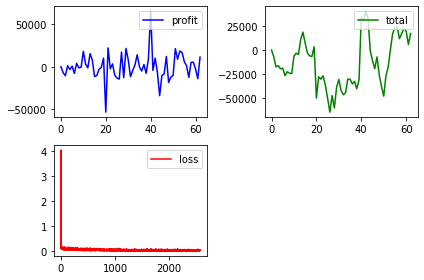

episode:  2
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

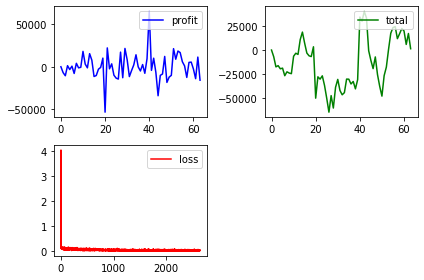

episode:  2
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

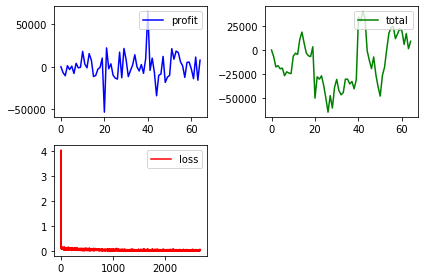

episode:  2
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

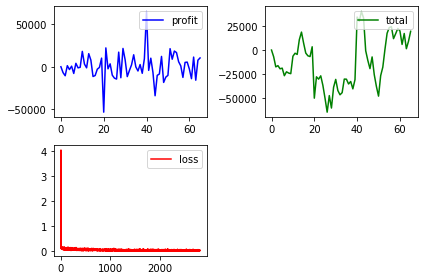

episode:  2
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  166
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  167
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL

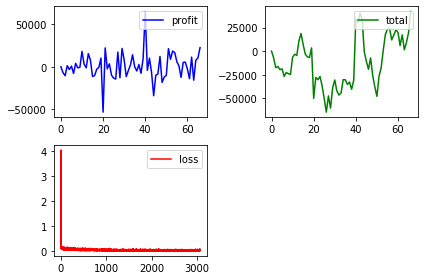

episode:  2
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

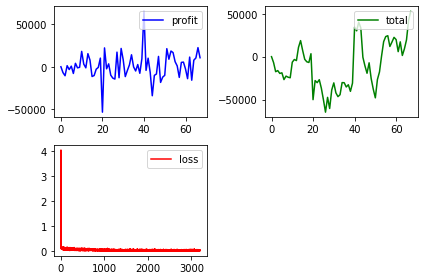

episode:  2
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

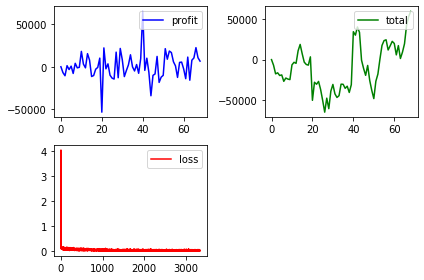

episode:  2
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

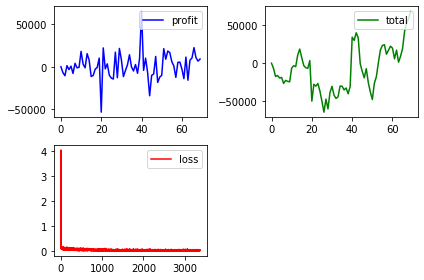

episode:  2
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 1
loss:  tensor(0.0050, grad_fn=

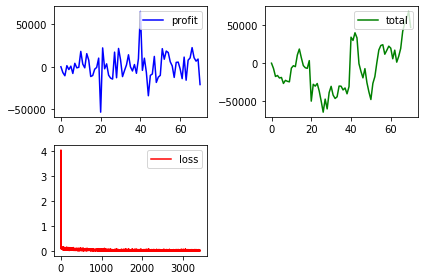

episode:  2
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  166
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  167
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  168
action 0
loss:  tensor(0.0050, grad_fn

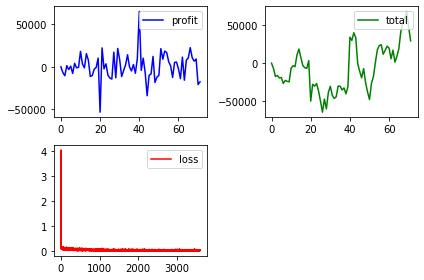

episode:  3
episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.00

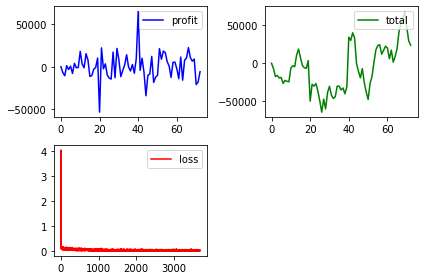

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

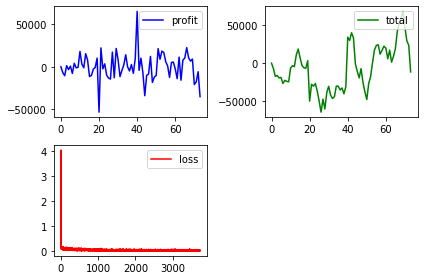

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

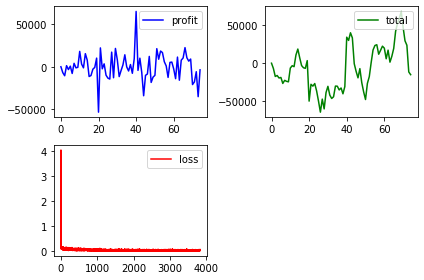

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL

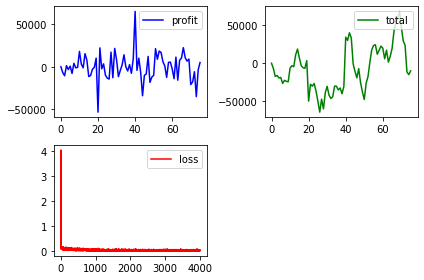

episode:  3
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

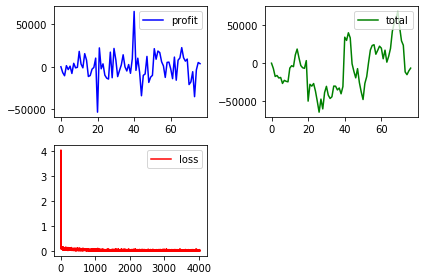

episode:  3
step:  0
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

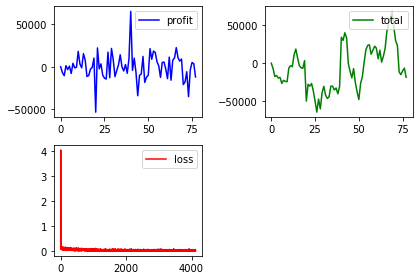

episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

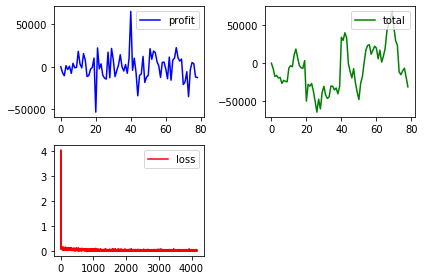

episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

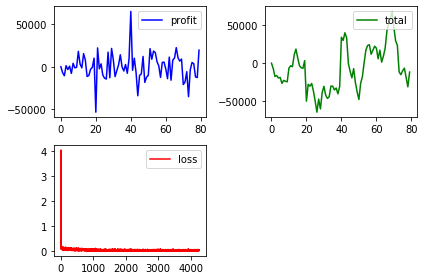

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

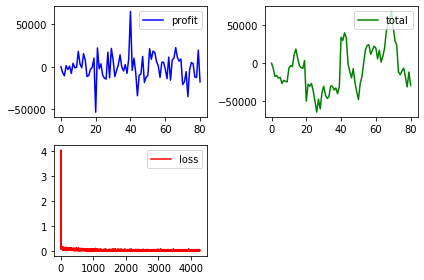

episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

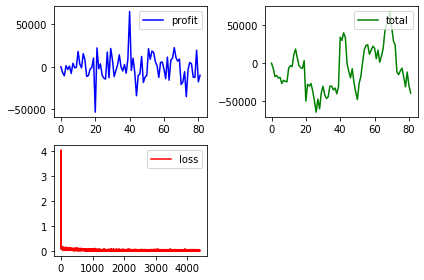

episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

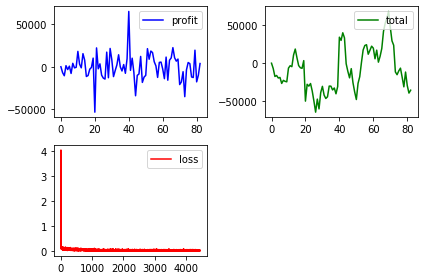

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

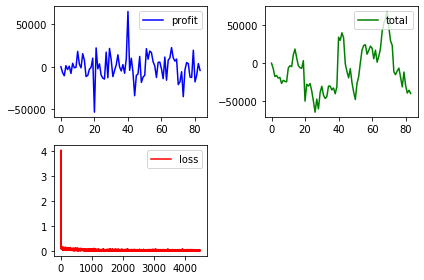

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

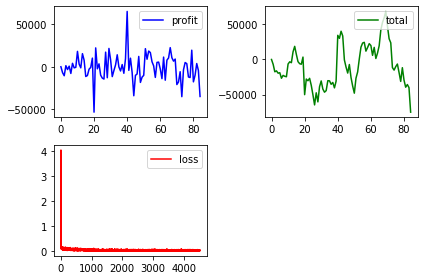

episode:  3
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

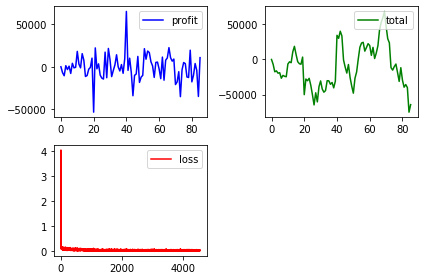

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

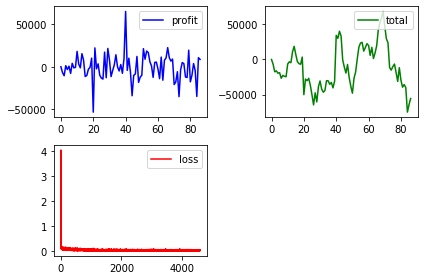

episode:  3
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

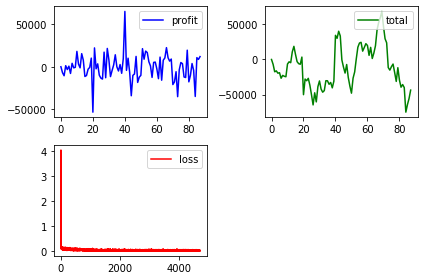

episode:  3
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

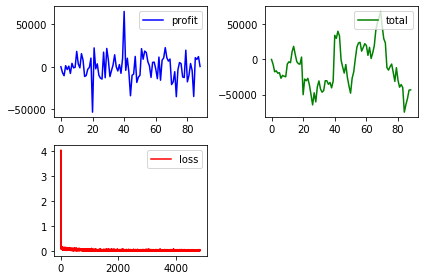

episode:  4
episode:  4
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.02

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  166
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  167
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  168
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  169
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  170
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  171
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  172
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL

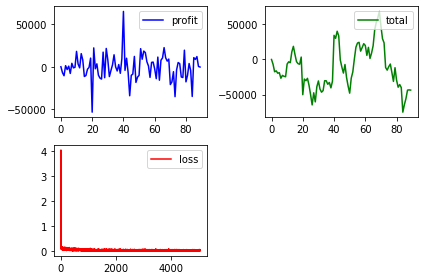

episode:  4
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 2
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

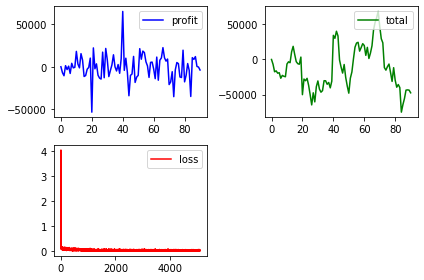

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

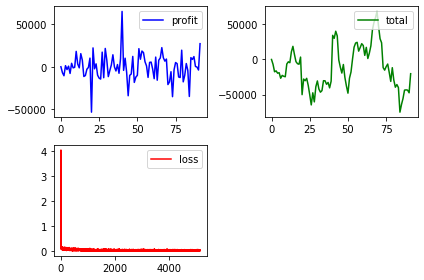

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

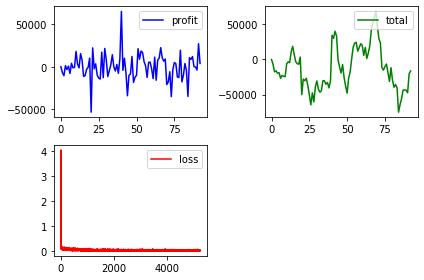

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

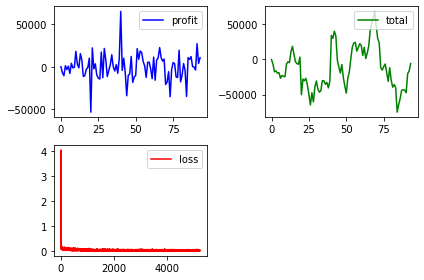

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

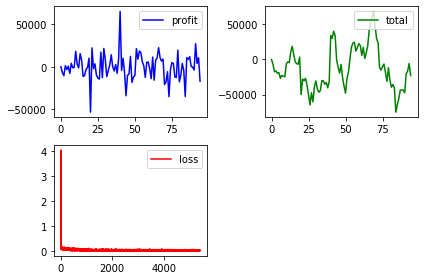

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

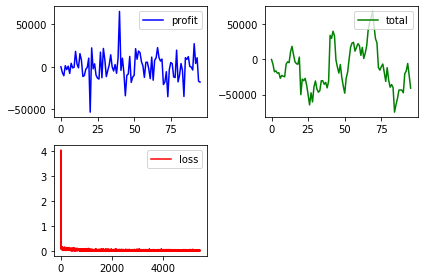

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

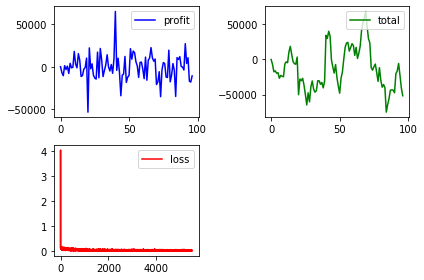

episode:  4
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  166
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  167
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  168
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  169
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  170
action 0
loss:  tensor(0.0050, grad_fn

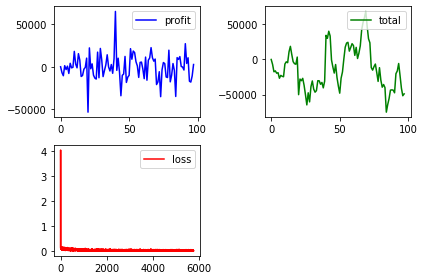

episode:  4
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

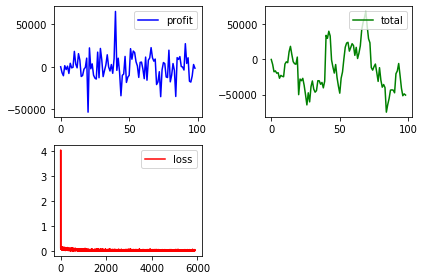

episode:  4
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

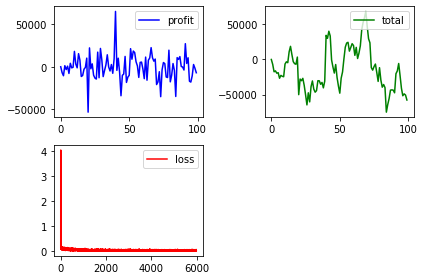

episode:  4
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

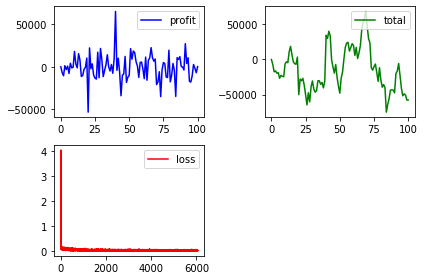

episode:  5
episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.00

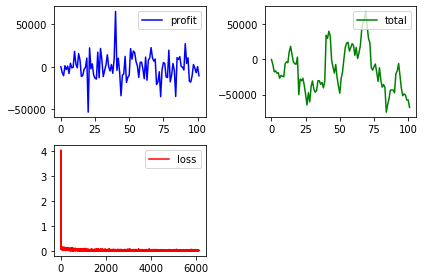

episode:  5
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

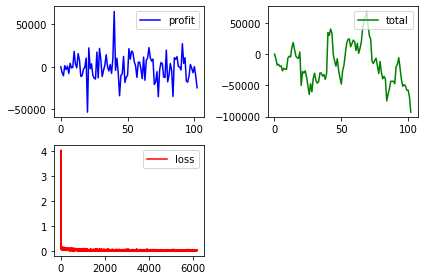

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

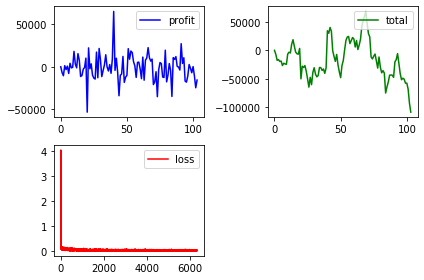

episode:  5
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

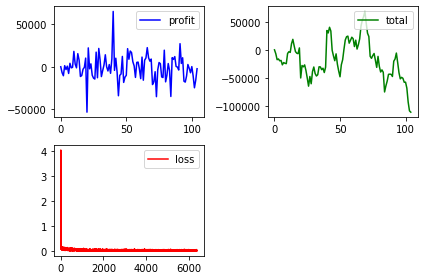

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

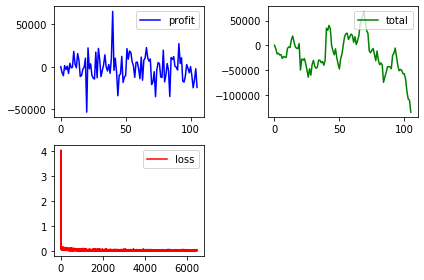

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

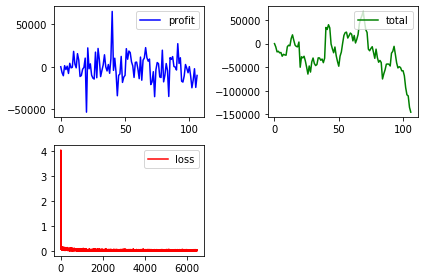

episode:  5
step:  0
action 0
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

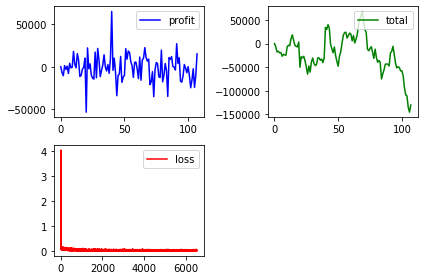

episode:  5
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

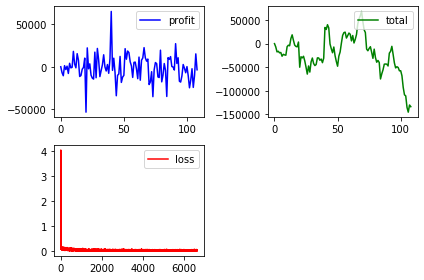

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

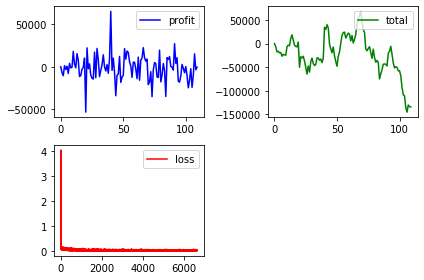

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

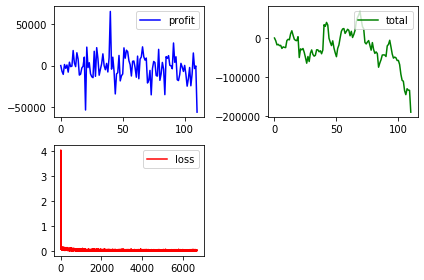

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

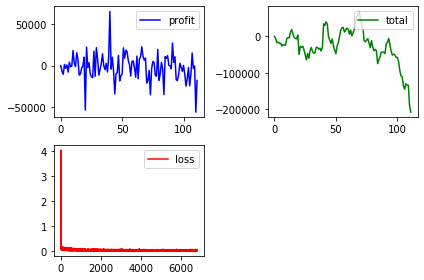

episode:  5
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  166
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  167
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL

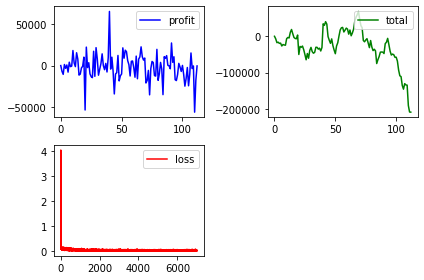

episode:  5
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

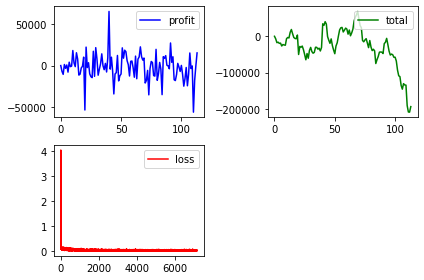

episode:  5
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

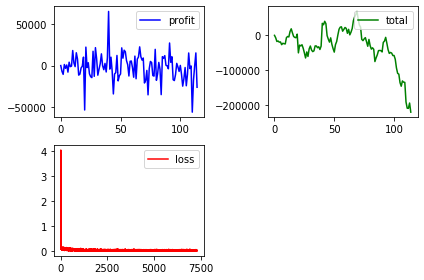

episode:  6
episode:  6
step:  0
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.02

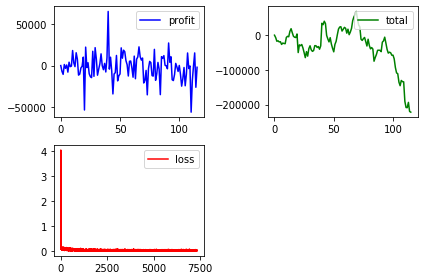

episode:  6
step:  0
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:25:30.375750, edate: 2020-03-08 00:25:30.412415, position: PositionType.LONG, profit: 6128.950470317391


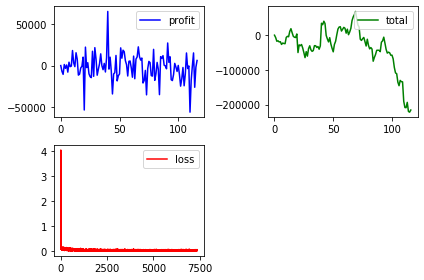

episode:  6
step:  0
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

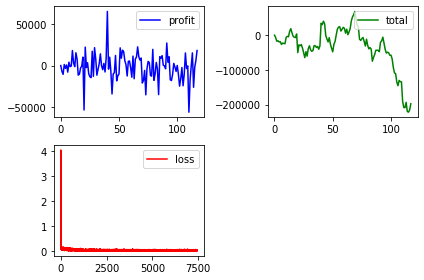

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

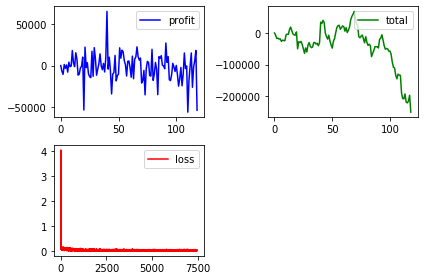

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

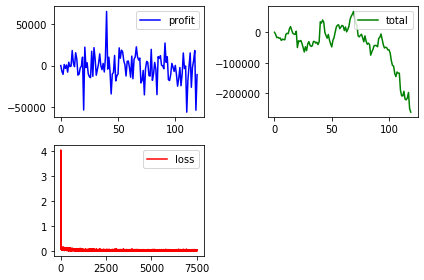

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

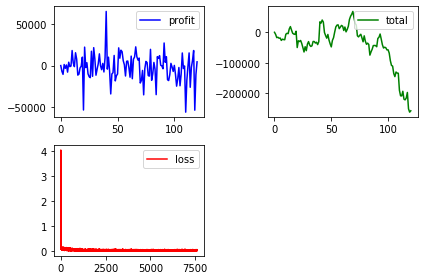

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

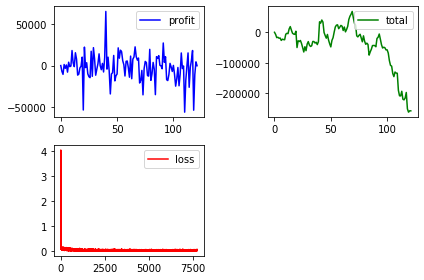

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

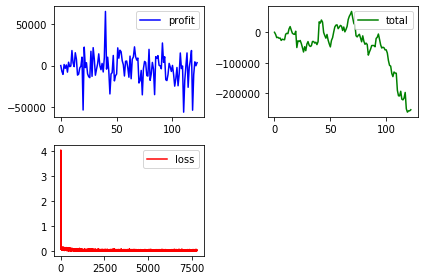

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

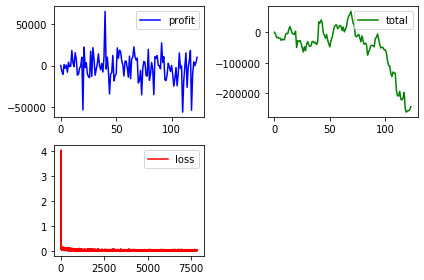

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

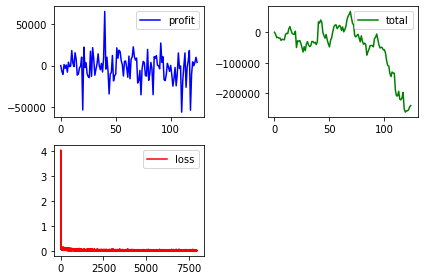

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

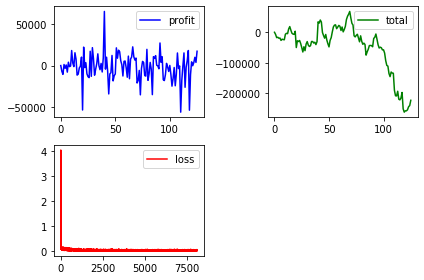

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 1
loss:  tensor(0.0669, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:25:37.353615, edate: 2020-03-08 00:25:37.361712, position: PositionType.LONG, profit: -5621.249324125362


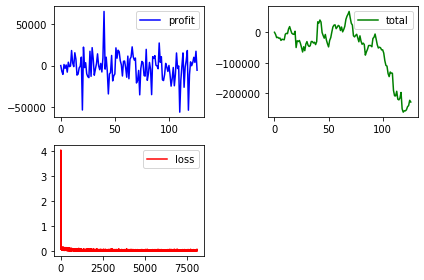

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

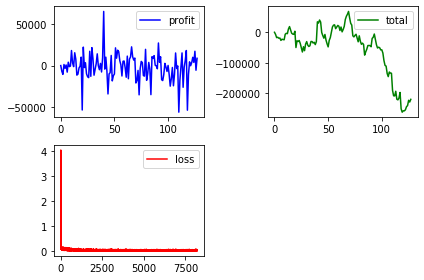

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

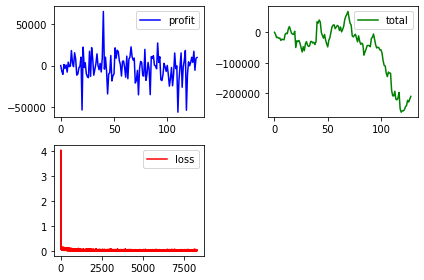

episode:  6
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

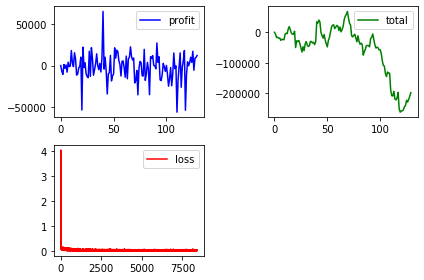

episode:  6
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

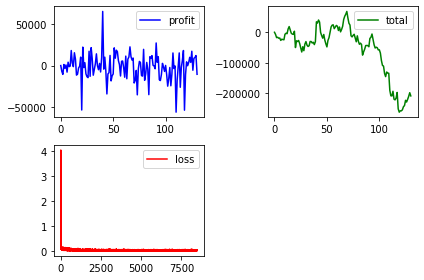

episode:  7
episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.00

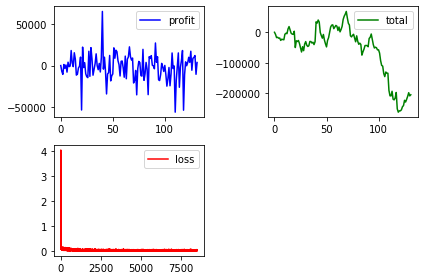

episode:  7
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

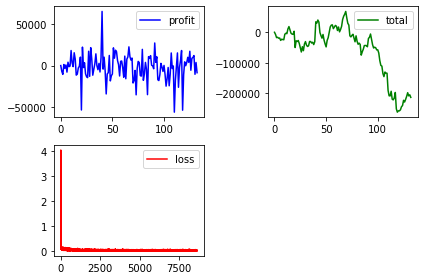

episode:  7
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

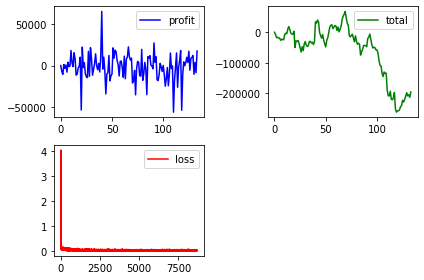

episode:  7
step:  0
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0514, grad_fn=

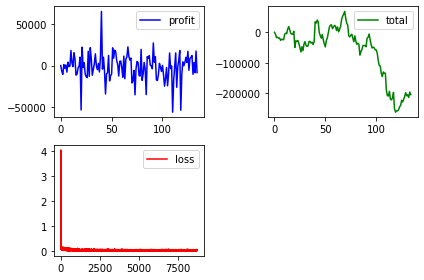

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

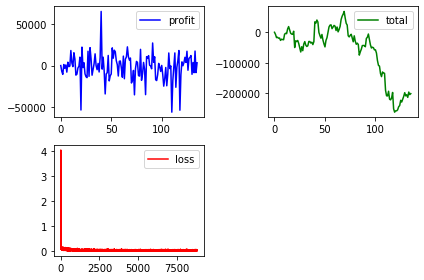

episode:  7
step:  0
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

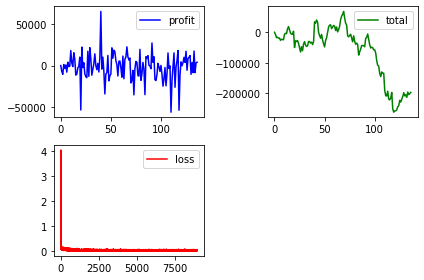

episode:  7
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

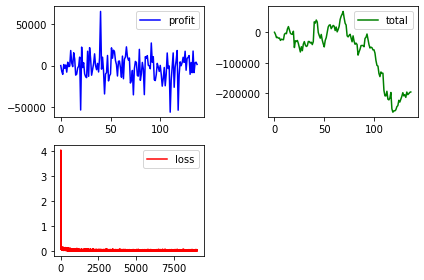

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

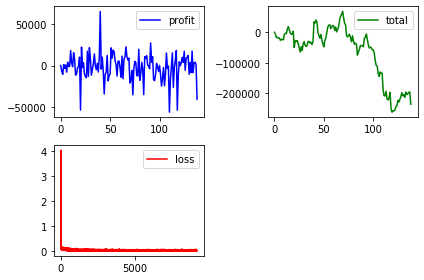

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

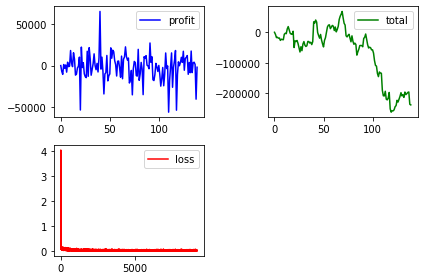

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 1
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:25:47.288105, edate: 2020-03-08 00:25:47.303700, position: PositionType.LONG, profit: -7999.209143810069


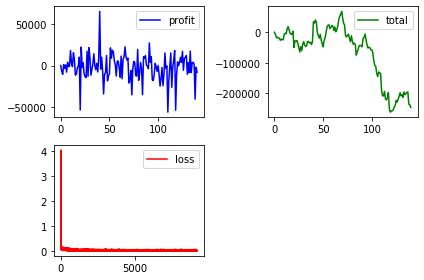

episode:  7
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

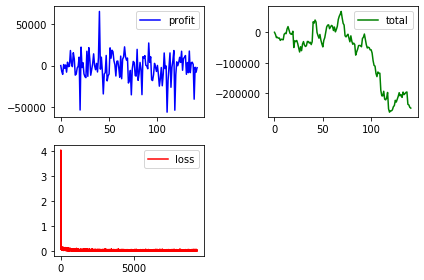

episode:  7
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

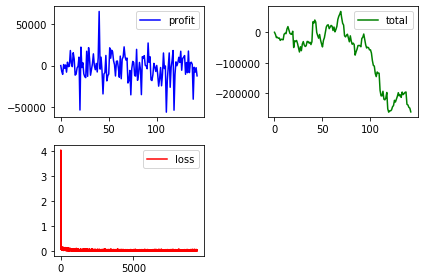

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

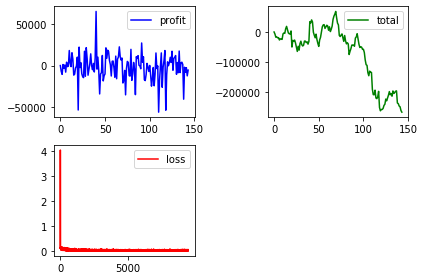

episode:  7
step:  0
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

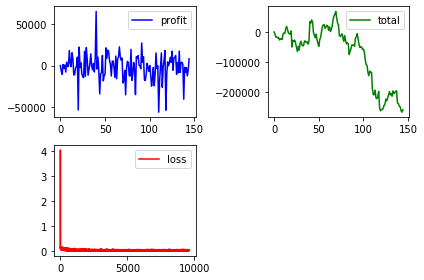

episode:  7
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0359, grad_fn=

loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  142
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  143
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  144
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  145
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  146
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  147
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  154
action 2
loss:  tensor(0.0359, grad_fn=<SmoothL

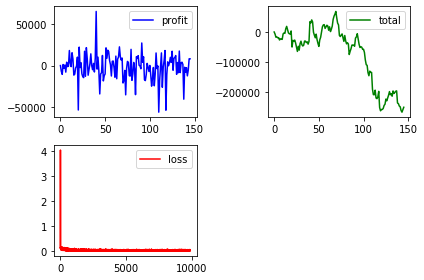

episode:  8
episode:  8
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.03

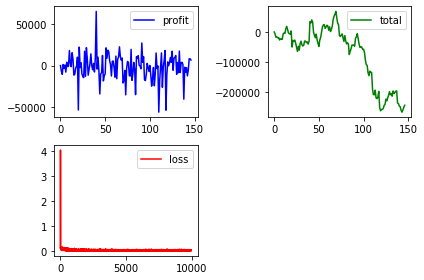

episode:  8
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

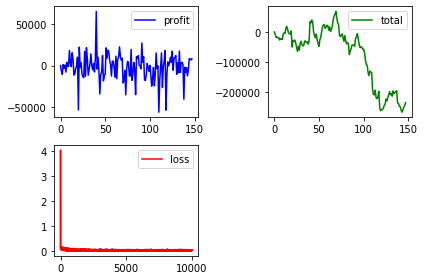

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0514, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  161
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  162
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  163
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  164
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  165
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL

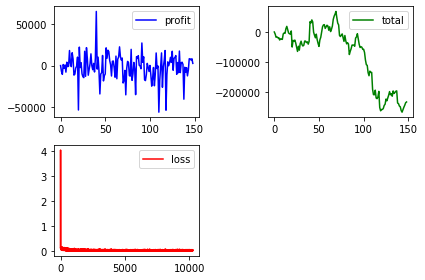

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

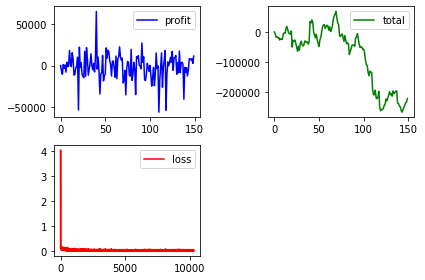

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

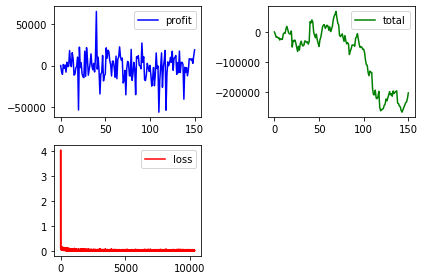

episode:  8
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

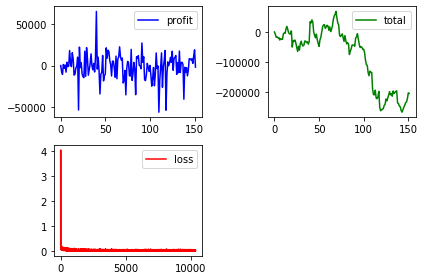

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

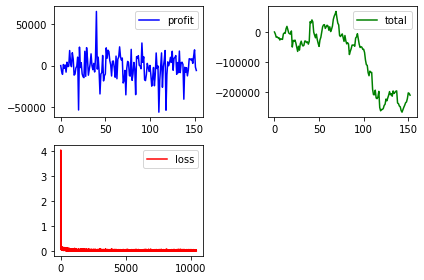

episode:  8
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

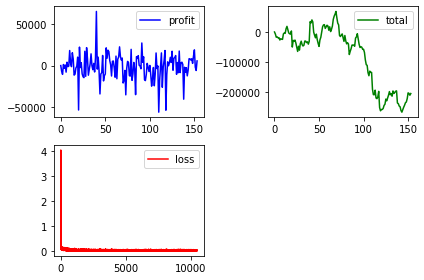

episode:  8
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  143
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  144
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  145
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  146
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  147
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0205, grad_fn

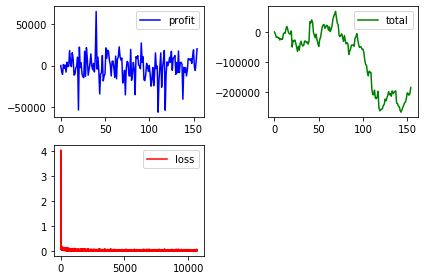

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

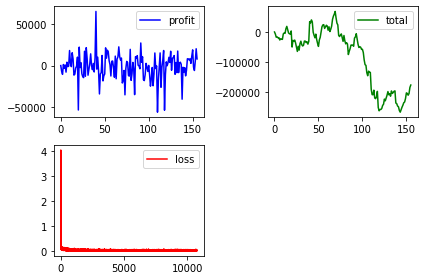

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

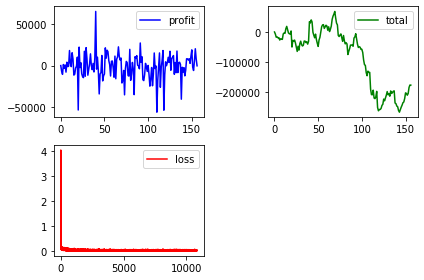

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 1
loss:  tensor(0.0050, grad_fn=

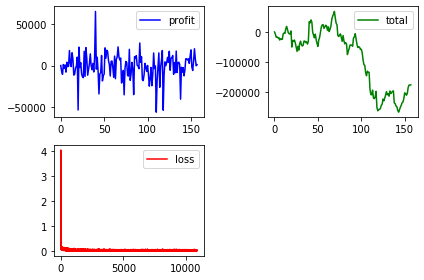

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

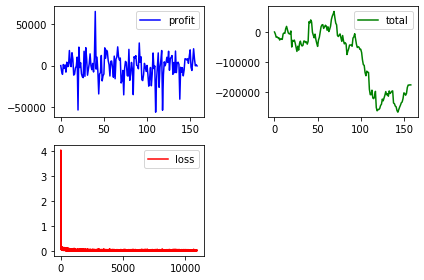

episode:  8
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 2
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

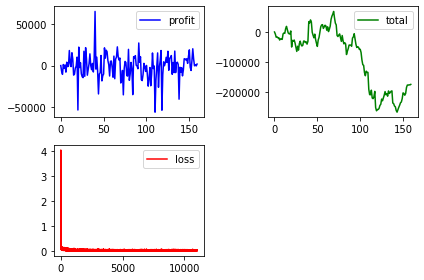

episode:  8
step:  0
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

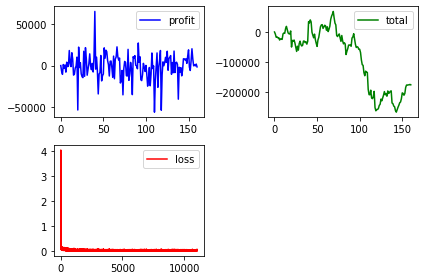

episode:  9
episode:  9
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.00

loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  157
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  158
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  159
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  160
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  288
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  289
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  290
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  291
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  292
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  293
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  294
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  295
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  296
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  297
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  298
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  299
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  300
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL

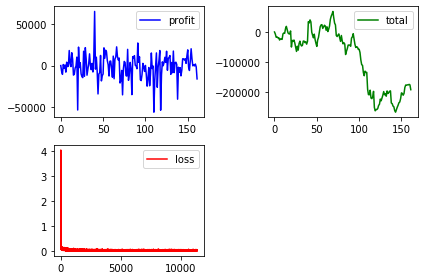

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  144
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  145
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  146
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  147
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  150
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  151
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  152
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  153
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  154
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  155
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  156
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL

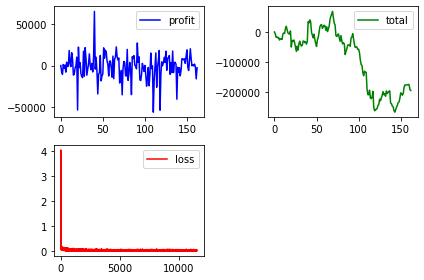

episode:  9
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0205, grad_fn=

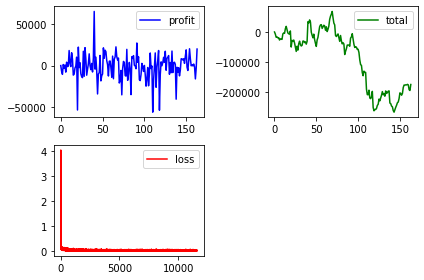

episode:  9
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

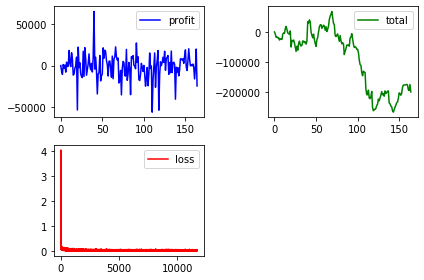

episode:  9
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 2
loss:  tensor(0.0050, grad_fn=

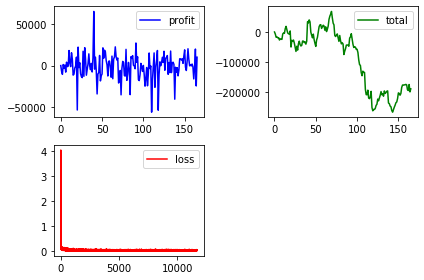

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

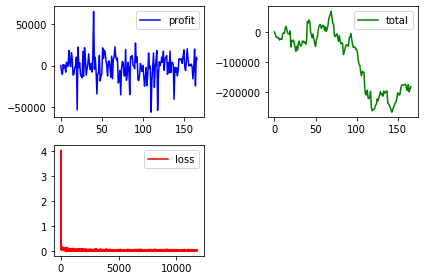

episode:  9
step:  0
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  5
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 2
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
sdate: 2020-03-08 00:26:08.448132, edate: 2020-03-08 00:26:08.469413, position: PositionType.LONG, profit: 1821.1197360624033


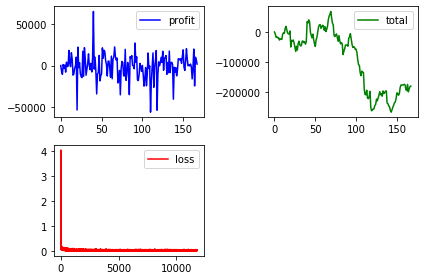

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

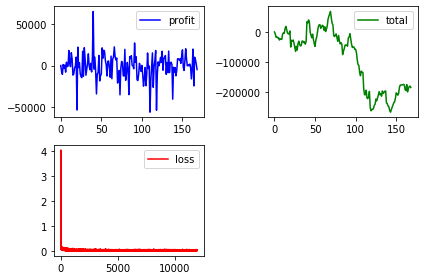

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 1
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 2
loss:  tensor(0.0050, grad_fn=

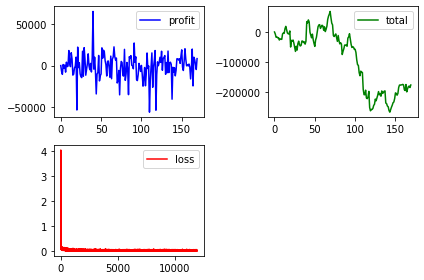

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

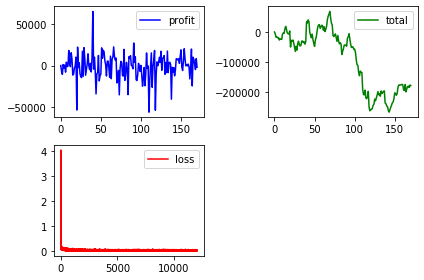

episode:  9
step:  0
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  1
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  2
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  3
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  4
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  5
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  6
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  7
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  8
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  9
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  10
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  11
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  12
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  13
action 0
loss:  tensor(0.0050, grad_fn=

loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  137
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  138
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  139
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  140
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  141
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  142
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL1LossBackward>)
step:  143
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  144
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  145
action 0
loss:  tensor(0.0359, grad_fn=<SmoothL1LossBackward>)
step:  146
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  147
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  148
action 0
loss:  tensor(0.0205, grad_fn=<SmoothL1LossBackward>)
step:  149
action 0
loss:  tensor(0.0050, grad_fn=<SmoothL

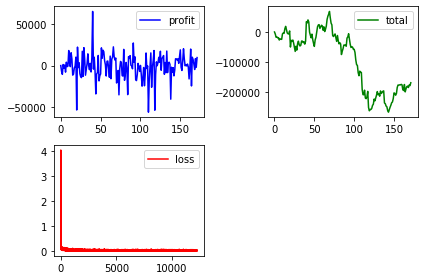

Complete


In [198]:
if __name__ == "__main__":
    
    ''' 環境生成 '''
    MONITOR = False
    env_param = EnvParameter(max_lot=1, spread=1, window_size=30)
    env = Environment(train_data, env_param, MONITOR)
    
    ''' エージェント生成 '''
    num_actions = env.get_action_num() 
    num_observ = env.get_observ_num()
    brain_param = BrainParameter(batch_size=32, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=200, capacity=10000, hidden_size=100)
    brain = Brain(brain_param, num_observ, num_actions)
    agent = Agent(brain)
    
    ''' Trainer '''
    cartpole_trainer = Trainer(env, agent)
    cartpole_trainer.train(10, 'dqn_simple_10.pth')
    

## Main(Eval)

### Main

In [321]:
if __name__ == "__main__":
    
    ''' 環境生成 '''
    MONITOR = False
    env_param = EnvParameter(max_lot=1, spread=1, window_size=30)
    env = Environment(valid_data, env_param, MONITOR, None)
    
    ''' エージェント生成 '''
    num_actions = env.get_action_num() 
    num_observ = env.get_observ_num()
    brain_param = BrainParameter(batch_size=32, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=200, capacity=10000, hidden_size=100)
    brain = Brain(brain_param, num_observ, num_actions)
    agent = Agent(brain)
    
    cartpole_examiner = Examiner(env, agent)
    cartpole_examiner.evaluate('weight.pth')
    

episode:  0
action:  0


TypeError: 'NoneType' object is not callable

# FX System Trade using DualingDQN

# FX System Trade using DQN with Prioritized Experience Replay

# FX System Trade using Gorila

# FX System Trade using A3C

# FX System Trade using Ape-X

# FX System Trade using R2D2

## Todo

- [x] evalの実装 : 2020-03-01
- [x] 対数差分系列の実装 : 2020-03-01
    - 正規化、標準化するべきかどうか
- [x] isFinishの実装 : 2020-03-01
- [x] データセットの分離（dataloader） : 2020-03-01
- [x] データをメインで用意してEnvに渡す : 2020-03-01
- どこでトレードしたかを見れるようにする
- 統計をもっと詳しくする（勝率、損益率等）
- いじるのをMainとBrainのみとしたい
    - envのstateを一定の出力とする必要がある（window * granu * ）

## Future works

- 評価結果をまとめる環境（あとから見直せる環境、modelname, 保存場所等）
- ベースモデルでの評価
- 報酬の与え方の再考
- 入力の再考
- 各種パラメータの再考
- 複数時間軸の採用
- モデルにLSTMを採用
- losscut,lot等の実装
- その他アルゴリズム、（リスク考慮型、福利考慮型、Rainbawなど）
    - Dualing DQN
    - Prioritized Experience Replay
    - Gorila
    - A3C
    - ApeX
    - R2D2

## 対数差分系列

### 原系列→対数差分系列

In [266]:
def get_data():
    h1_df = import_csv_data(PairType.USD_JPY, GranularityType.H1)
    h1_df["log_ratio"] = np.log(h1_df['close'])-np.log(h1_df['close'].shift(1))
    h1_df = h1_df.dropna(how='any')
    print(h1_df.log_ratio)
    return h1_df.log_ratio.values

In [267]:
train_valid_data, test_data = train_test_split(get_data(), test_size=0.2)
train_data, valid_data = train_test_split(train_valid_data, test_size=0.2)
print("train_data: ", train_data.shape)
print("valid_data: ", valid_data.shape)
print("test_data: ", test_data.shape)

                            time  volume     high      low     open    close
0      2005-07-01 00:00:00+00:00  2008.0  110.866  110.620  110.740  110.846
1      2005-07-01 01:00:00+00:00  2229.0  111.120  110.820  110.846  110.950
2      2005-07-01 02:00:00+00:00  1610.0  110.990  110.860  110.970  110.860
3      2005-07-01 03:00:00+00:00   834.0  110.920  110.860  110.860  110.900
4      2005-07-01 04:00:00+00:00  1868.0  111.096  110.820  110.900  111.016
...                          ...     ...      ...      ...      ...      ...
93031  2020-01-23 19:00:00+00:00  2389.0  109.536  109.464  109.472  109.523
93032  2020-01-23 20:00:00+00:00  1503.0  109.528  109.476  109.521  109.494
93033  2020-01-23 21:00:00+00:00  1058.0  109.512  109.458  109.495  109.494
93034  2020-01-23 22:00:00+00:00   211.0  109.541  109.484  109.490  109.527
93035  2020-01-23 23:00:00+00:00   928.0  109.572  109.506  109.528  109.567

[93036 rows x 6 columns]
1        0.000938
2       -0.000812
3        0.000

### 対数差分系列→原系列

In [268]:
def convert_original(log_ratio_df):
    h1_df["log_ratio"] = np.log(h1_df['close'])-np.log(h1_df['close'].shift(1))
    h1_df = h1_df.dropna(how='any')
    print(h1_df.log_ratio)
    return 0

In [269]:
convert_original(train_data)

0

# Report

## Todo

- [x] evalの実装 : 2020-03-01
- [x] 対数差分系列の実装 : 2020-03-01
    - [ ] 結果を可視化する
    - 正規化、標準化するべきかどうか
- [x] isFinishの実装 : 2020-03-01
- [x] データセットの分離（dataloader） : 2020-03-01
- [x] データをメインで用意してEnvに渡す : 2020-03-01
- [ ] 統計をもっと詳しくする（勝率、損益率等）
    - [x] stats
    - [x] graph八割（うまく表示できていない）
    - [ ] trade内容可視化
- [ ] 訓練結果保存
    - [ ] model(.pth)保存 : 上書きされないように最初にエラーを表示する
    - [ ] parameter(parameter.json)
    - [ ] loss_transition(csv)
    - [ ] profit_transition(csv)
    - [ ] transactions(csv)
- [ ] リファクタリング：いじるのをMainとBrainのみとしたい
    - envのstateを一定の出力とする必要がある（window * granu * ）
- [ ] episodeで同じデータを回す
    - [ ] 1episodeごとに検証する
    - [ ] tqdmで残り時間を表示
    - [ ] simple dqmで試してみる
- [ ] DQN with lstm

## Future Works

- 評価結果をまとめる環境（あとから見直せる環境、modelname, 保存場所等）
    - modelを保存
    - README.md(training内容)を保存
        - parameter
        - loss_transition
        - profit_transition
    - transactionsを保存
- ベースモデルでの評価
- 報酬の与え方の再考
- 入力の再考
- 各種パラメータの再考
- 複数時間軸の採用
- モデルにLSTMを採用
- losscut,lot等の実装
- その他アルゴリズム、（リスク考慮型、福利考慮型、Rainbawなど）
    - Dualing DQN
    - Prioritized Experience Replay
    - Gorila
    - A3C
    - ApeX
    - R2D2

## 2020-03-07

- [x] RewardFuncを削除
- [x] statisticsの実装
- [x] 論文を読む
    - NT 倍率取引における深層強化学習を用いた投資戦略の構築
        - https://www.ieice.org/publications/conference-FIT-DVDs/FIT2018/data/pdf/A-008.pdf
        - 両建て手法による複利型強化学習
        - 指標がどうやってきめてるんだろう。決め打ち感あるな、、
        - 指標：ボリンジャーバンドの過去k区間の正規化、NT倍率、短期、中期、長期、所有現金の初期資産に対する割合、全11種類
        - 全結合NN。指標に過去の値動きが入っていることを想定している (lstmのほうがいいんじゃないかなあ、)
        - データ全てで取引を終えることを1エピソードとしている（なるほど！）
    - 金融取引戦略獲得のための複利型深層強化学習
        - https://sigfin.org/?plugin=attach&refer=SIG-FIN-016-01&openfile=SIG-FIN-016-01.pdf
        - 訓練は同じやつを繰り返していくの？？
        - 検証で同じデータを使ってない？
        - 全結合NN：指標：ボリンジャーバンドと現在値の過去k区間の正規化
    - 強化学習を用いた金融市場における日次取引戦略の獲得
        - https://www.jstage.jst.go.jp/article/pjsai/JSAI2009/0/JSAI2009_3G3OS125/_pdf
        - 日時取引の際の土日またぎの影響をその分割引率をあげることで解消を図る
        - 